# Installs & Imports

In [1]:
!pip install --upgrade pip --quiet

!pip install torch \
             torchvision \
             protobuf \
             utilsd \
             click \
             sktime \
             tqdm \
             tensorboard \
             numba \
             spikingjelly \
             tables \
             matplotlib \
             plotly \
             kaleido \
             "dask[dataframe]" \
             yfinance \
             optuna \
             dataframe_image \
             selenium --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 123.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import time
import random
import math
import copy
from typing import List, Dict, Tuple, Optional, Union, Any
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

import plotly.express as px
import plotly.io as pio
from plotly.graph_objects import Figure

from IPython.display import display, Image, SVG
from io import BytesIO
import dataframe_image as dfi

from spikingjelly.activation_based import surrogate, neuron, functional

import yfinance as yf
import optuna
from optuna import Trial
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_pareto_front,
    plot_hypervolume_history
)

from google.colab import files

# Data Loading

In [3]:
def load_data() -> pd.DataFrame:
    """
    Fetches daily AAPL closing prices from January 1, 2010, to January 1, 2020, using yfinance.

    Returns:
        pd.DataFrame: A DataFrame with a DatetimeIndex and a single column 'Value' for the close price.
    """
    df = yf.download('AAPL', start='2010-01-01', end='2020-01-01', progress=False)
    df = pd.DataFrame(df['Close'].values, index=df.index, columns=['Value'])
    return df

# Load the dataset
df = load_data()
display(df.head(30))
print(f"\nDataset shape: {df.shape}")

,Value
Date,
2010-01-04,7.643214
2010-01-05,7.656429
2010-01-06,7.534643
2010-01-07,7.520714
2010-01-08,7.570714
2010-01-11,7.503929
2010-01-12,7.418571
2010-01-13,7.523214
2010-01-14,7.479643



Dataset shape: (2516, 1)


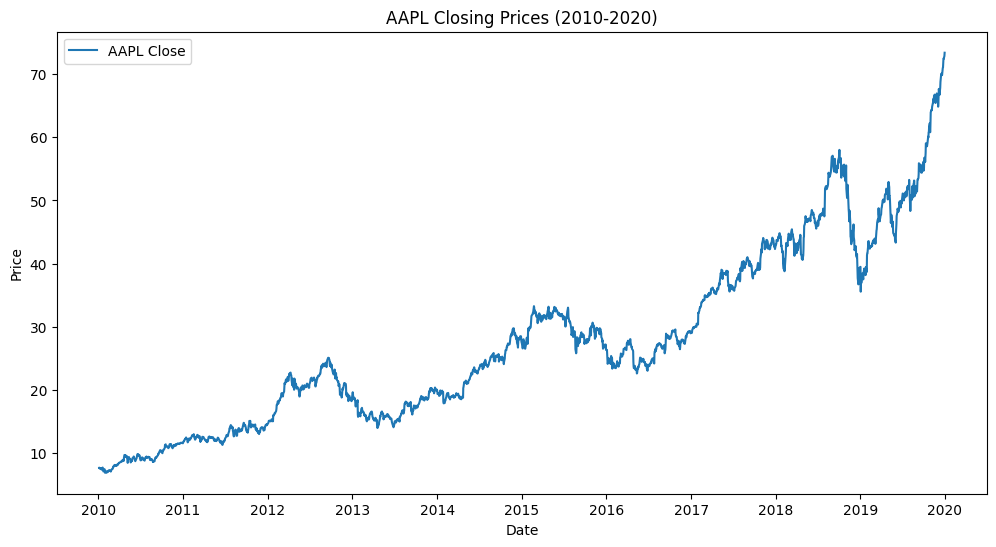

Dataset length: 2516 data points


In [4]:
def visualize_data(df: pd.DataFrame) -> None:
    """
    Plots the time series data to visualize AAPL's closing price behavior.

    Args:
        df (pd.DataFrame): The DataFrame containing a datetime index and a 'Value' column.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Value'], label='AAPL Close')
    plt.title('AAPL Closing Prices (2010-2020)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    print(f"Dataset length: {len(df)} data points")

# Visualize the time series
visualize_data(df)

# Data Preprocessing

In [5]:
class TimeSeriesPreprocessor:
    """
    Preprocesses time series data for modeling. The preprocessing steps include:
        - Adding time-based features
        - Splitting data into train, validation, and test sets
        - Normalizing the target series
        - Creating sequences for model input
        - Generating PyTorch Datasets and DataLoaders

    Attributes:
        df (pd.DataFrame): The original DataFrame with a DatetimeIndex.
        target_col (str): Name of the column to be used as the target variable.
        time_features (List[str]): List of time-based features to be extracted.
        split_proportions (Tuple[float, float, float]): Proportions for train, validation, test splits.
        scaling_method (str): The normalization strategy for the target column.
        window (int): Number of past timesteps to use for a sequence.
        horizon (int): Number of future timesteps to predict (forecast horizon).
        split_overlap (bool): Whether to allow overlap between splits.
        batch_size (int): Batch size for the DataLoaders.
        train_shuffle (bool): Whether to shuffle the train set.
        dataloader_kwargs (Dict[str, Any]): Additional arguments for DataLoader.
        concat_time_features (bool): If True, time features are concatenated to X.
        scaling_params (Dict[str, Any]): Parameters used for normalization.
        split_dates (Dict[str, Dict[str, Tuple[pd.Timestamp, pd.Timestamp]]]): Date ranges for splits.
        data_loaders (Dict[str, DataLoader]): DataLoaders for train, validation, and test sets.
    """

    def __init__(
        self,
        df: pd.DataFrame,
        target_col: str,
        time_features: List[str],
        split_proportions: Tuple[float, float, float] = (0.7, 0.15, 0.15),
        scaling_method: str = 'zscore',
        window: int = 60,
        horizon: int = 1,
        split_overlap: bool = False,
        batch_size: int = 32,
        train_shuffle: bool = True,
        dataloader_kwargs: Optional[Dict[str, Any]] = None,
        concat_time_features: bool = True
    ):
        """
        Initializes the TimeSeriesPreprocessor with the provided parameters.

        Args:
            df (pd.DataFrame): The original DataFrame with a DatetimeIndex.
            target_col (str): Name of the column to be used as the target variable.
            time_features (List[str]): List of time-based features to be extracted from the DatetimeIndex.
            split_proportions (Tuple[float, float, float], optional): Proportions for train, validation, test splits.
                Must sum to 1.0. Defaults to (0.7, 0.15, 0.15).
            scaling_method (str, optional): The normalization strategy for the target column.
                Options: 'zscore', 'minmax', 'robust'. Defaults to 'zscore'.
            window (int, optional): Number of past timesteps to use for a sequence. Defaults to 60.
            horizon (int, optional): Number of future timesteps to predict (forecast horizon). Defaults to 1.
            split_overlap (bool, optional): Whether to allow overlap between splits. Defaults to False.
            batch_size (int, optional): Batch size for the DataLoaders. Defaults to 32.
            train_shuffle (bool, optional): Whether to shuffle the train set. Defaults to True.
            dataloader_kwargs (Dict[str, Any], optional): Additional arguments passed to DataLoader. Defaults to None.
            concat_time_features (bool, optional): If True, time features are concatenated to X. Otherwise, X and X_tf are kept separate.
                Defaults to True.
        """
        self.df = df.copy()
        self.target_col = target_col
        self.time_features = time_features
        self.split_proportions = split_proportions
        self.scaling_method = scaling_method.lower()
        self.window = window
        self.horizon = horizon
        self.split_overlap = split_overlap
        self.batch_size = batch_size
        self.train_shuffle = train_shuffle
        self.dataloader_kwargs = dataloader_kwargs if dataloader_kwargs else {}
        self.concat_time_features = concat_time_features

        # For storing scaling params, date ranges, and DataLoaders
        self.scaling_params: Dict[str, Any] = {}
        self.split_dates: Dict[str, Dict[str, Tuple[pd.Timestamp, pd.Timestamp]]] = {
            'raw': {},
            'sequence': {}
        }
        self.data_loaders: Dict[str, DataLoader] = {}

        self._validate_inputs()

    def _validate_inputs(self) -> None:
        """Validates the initial data assumptions and parameter values.

        Raises:
            ValueError: If the DataFrame does not have a DatetimeIndex.
            ValueError: If the target column is not found in the DataFrame.
            ValueError: If any of the provided time features are invalid.
            ValueError: If split proportions do not sum to 1.0.
            ValueError: If the scaling method is not supported.
        """
        if not isinstance(self.df.index, pd.DatetimeIndex):
            raise ValueError("DataFrame must have a DatetimeIndex.")

        if self.target_col not in self.df.columns:
            raise ValueError(f"Target column '{self.target_col}' not found in DataFrame.")

        valid_features = {'quarter', 'month', 'weekofyear', 'dayofweek', 'dayofyear', 'hour', 'minute'}
        if not set(self.time_features).issubset(valid_features):
            invalid = set(self.time_features) - valid_features
            raise ValueError(f"Invalid time features: {invalid}. Allowed: {valid_features}")

        if not np.isclose(sum(self.split_proportions), 1.0):
            raise ValueError("Split proportions must sum to 1.0.")

        if self.scaling_method not in {'zscore', 'minmax', 'robust'}:
            raise ValueError("scaling_method must be one of {'zscore', 'minmax', 'robust'}.")

    def add_time_features(self) -> None:
        """Adds specified time-based features (e.g., quarter, month) to the DataFrame."""
        for feature in self.time_features:
            if feature == 'quarter':
                self.df['quarter'] = self.df.index.quarter
            elif feature == 'month':
                self.df['month'] = self.df.index.month
            elif feature == 'weekofyear':
                self.df['weekofyear'] = self.df.index.isocalendar().week
            elif feature == 'dayofweek':
                self.df['dayofweek'] = self.df.index.dayofweek + 1
            elif feature == 'dayofyear':
                self.df['dayofyear'] = self.df.index.dayofyear
            elif feature == 'hour':
                self.df['hour'] = self.df.index.hour
            elif feature == 'minute':
                self.df['minute'] = self.df.index.minute

        print("\nAdded time-based features:")
        display(self.df[self.time_features].head(10))
        print("\n")
        display(self.df[self.time_features].tail(10))

    def split_data(self) -> None:
        """Splits the data into train, validation, and test DataFrames based on split proportions."""
        total_length = len(self.df)
        train_end = int(total_length * self.split_proportions[0])
        val_end = train_end + int(total_length * self.split_proportions[1])

        train_df = self.df.iloc[:train_end]
        val_df = self.df.iloc[train_end:val_end]
        test_df = self.df.iloc[val_end:]

        self.split_dates['raw']['train'] = (train_df.index.min(), train_df.index.max())
        self.split_dates['raw']['validation'] = (val_df.index.min(), val_df.index.max())
        self.split_dates['raw']['test'] = (test_df.index.min(), test_df.index.max())

        print("\nData Splits (Before Sequence Creation):")
        print(f"Train: {train_df.shape} | {self.split_dates['raw']['train']}")
        print(f"Validation: {val_df.shape} | {self.split_dates['raw']['validation']}")
        print(f"Test: {test_df.shape} | {self.split_dates['raw']['test']}\n")

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

    def plot_splits(self) -> None:
        """Visualizes the train, validation, and test boundaries over the time series."""
        plt.figure(figsize=(15, 5))

        plt.plot(self.train_df.index, self.train_df[self.target_col], label='Train')
        plt.plot(self.val_df.index, self.val_df[self.target_col], label='Validation')
        plt.plot(self.test_df.index, self.test_df[self.target_col], label='Test')

        # Vertical lines to separate splits
        plt.axvline(self.val_df.index.min(), color='k', linestyle='--', linewidth=1)
        plt.axvline(self.test_df.index.min(), color='k', linestyle='--', linewidth=1)

        plt.xlabel('Date')
        plt.ylabel(self.target_col)
        plt.title('Train, Validation, and Test Splits')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def normalize(self) -> None:
        """Normalizes the target column based on the specified scaling method."""
        train_values = self.train_df[self.target_col]

        if self.scaling_method == 'zscore':
            mean_ = train_values.mean()
            std_ = train_values.std()
            self.scaling_params = {'mean': mean_, 'std': std_}

            self.df[self.target_col] = (self.df[self.target_col] - mean_) / std_

            print(f"\nApplied Z-score scaling: mean={mean_:.4f}, std={std_:.4f}")

        elif self.scaling_method == 'minmax':
            min_ = train_values.min()
            max_ = train_values.max()
            self.scaling_params = {'min': min_, 'max': max_}

            self.df[self.target_col] = (self.df[self.target_col] - min_) / (max_ - min_)

            print(f"\nApplied Min-Max scaling: min={min_:.4f}, max={max_:.4f}")

        elif self.scaling_method == 'robust':
            median_ = train_values.median()
            q1_ = train_values.quantile(0.25)
            q3_ = train_values.quantile(0.75)
            iqr_ = q3_ - q1_
            self.scaling_params = {'median': median_, 'q1': q1_, 'q3': q3_}

            self.df[self.target_col] = (self.df[self.target_col] - median_) / iqr_

            print(f"\nApplied Robust scaling: median={median_:.4f}, q1={q1_:.4f}, q3={q3_:.4f}")

        # Update the split DataFrames with normalized data
        self.train_df = self.df.loc[self.train_df.index]
        self.val_df = self.df.loc[self.val_df.index]
        self.test_df = self.df.loc[self.test_df.index]

    def create_sequences(self) -> None:
        """
        Creates sequences for train, validation, and test sets.
        If split_overlap=True, includes some data from the preceding set.
        """

        def generate_sequences(
            current_df: pd.DataFrame,
            previous_df: Optional[pd.DataFrame],
            split_name: str
        ) -> Dict[str, np.ndarray]:
            """
            Generates sequences for a given split.

            Args:
                current_df (pd.DataFrame): The DataFrame for the current split.
                previous_df (Optional[pd.DataFrame]): The DataFrame for the preceding split, if overlap is allowed.
                split_name (str): Name of the split (e.g., 'train', 'validation', 'test').

            Returns:
                Dict[str, np.ndarray]: A dictionary containing X, y, and X_tf sequences.
            """
            X_list, y_list, X_tf_list = [], [], []

            if self.split_overlap and previous_df is not None:
                combined_df = pd.concat([previous_df.iloc[-self.window:], current_df])
            else:
                combined_df = current_df

            data_values = combined_df[self.target_col].values.astype(np.float32)
            time_features = combined_df[self.time_features].values.astype(np.float32)

            for i in range(len(data_values) - self.window - self.horizon + 1):
                X_seq = data_values[i : i + self.window]
                y_seq = data_values[i + self.window : i + self.window + self.horizon]
                X_tf_seq = time_features[i : i + self.window]

                X_list.append(X_seq)
                y_list.append(y_seq)
                X_tf_list.append(X_tf_seq)

            print(f"\n{split_name.capitalize()} set sequences:")
            print(f"X_seq shape: {np.array(X_list).shape}")
            print(f"y_seq shape: {np.array(y_list).shape}")
            print(f"X_tf shape: {np.array(X_tf_list).shape}")

            seq_start_date = combined_df.index[self.window]
            seq_end_date = (
                combined_df.index[-self.horizon]
                if self.horizon > 0
                else combined_df.index[-1]
            )

            self.split_dates['sequence'][split_name] = (seq_start_date, seq_end_date)

            return {
                'X': np.expand_dims(np.array(X_list), axis=-1),  # Shape: (samples, window, 1)
                'y': np.array(y_list),                           # Shape: (samples, horizon)
                'X_tf': np.array(X_tf_list)                      # Shape: (samples, window, #time_features)
            }

        self.train_sequences = generate_sequences(self.train_df, None, 'train')
        self.val_sequences = generate_sequences(self.val_df, self.train_df, 'validation')
        self.test_sequences = generate_sequences(self.test_df, self.val_df, 'test')

    def create_datasets_and_dataloaders(self) -> None:
        """Creates PyTorch Datasets and DataLoaders for train, validation, and test sets."""

        class TimeSeriesDataset(Dataset):
            """
            Custom PyTorch Dataset for time series sequences.
            """

            def __init__(
                self,
                X: np.ndarray,
                y: np.ndarray,
                X_tf: np.ndarray,
                concat_time_features: bool = True
            ):
                """
                Initializes the TimeSeriesDataset.

                Args:
                    X (np.ndarray): Input sequences of shape (samples, window, 1).
                    y (np.ndarray): Target sequences of shape (samples, horizon).
                    X_tf (np.ndarray): Time feature sequences of shape (samples, window, num_feats).
                    concat_time_features (bool, optional): If True, concatenates time features to X. Defaults to True.
                """
                if concat_time_features:
                    # Concatenate X (samples, window, 1) and X_tf (samples, window, num_feats) along the last dimension
                    self.X = torch.tensor(np.concatenate((X, X_tf), axis=-1), dtype=torch.float32)
                    self.y = torch.tensor(y, dtype=torch.float32)
                else:
                    self.X = torch.tensor(X, dtype=torch.float32)
                    self.y = torch.tensor(y, dtype=torch.float32)
                    self.X_tf = torch.tensor(X_tf, dtype=torch.float32)

                self.concat_time_features = concat_time_features

            def __len__(self) -> int:
                """Returns the total number of samples."""
                return len(self.X)

            def __getitem__(self, idx: int) -> Union[Tuple[Tensor, Tensor], Tuple[Tensor, Tensor, Tensor]]:
                """
                Retrieves the sample at the specified index.

                Args:
                    idx (int): Index of the sample to retrieve.

                Returns:
                    Union[Tuple[Tensor, Tensor], Tuple[Tensor, Tensor, Tensor]]:
                        - If concat_time_features is True: (X, y)
                        - Else: (X, y, X_tf)
                """
                if self.concat_time_features:
                    return self.X[idx], self.y[idx]
                else:
                    return self.X[idx], self.y[idx], self.X_tf[idx]

        # Instantiate dataset objects
        train_dataset = TimeSeriesDataset(
            X=self.train_sequences['X'],
            y=self.train_sequences['y'],
            X_tf=self.train_sequences['X_tf'],
            concat_time_features=self.concat_time_features
        )
        val_dataset = TimeSeriesDataset(
            X=self.val_sequences['X'],
            y=self.val_sequences['y'],
            X_tf=self.val_sequences['X_tf'],
            concat_time_features=self.concat_time_features
        )
        test_dataset = TimeSeriesDataset(
            X=self.test_sequences['X'],
            y=self.test_sequences['y'],
            X_tf=self.test_sequences['X_tf'],
            concat_time_features=self.concat_time_features
        )

        print("\nDataset shapes:")
        if self.concat_time_features:
            print("Concatenated Mode: X + X_tf")
            print(f"Train - X: {train_dataset.X.shape}, y: {train_dataset.y.shape}")
            print(f"Validation - X: {val_dataset.X.shape}, y: {val_dataset.y.shape}")
            print(f"Test - X: {test_dataset.X.shape}, y: {test_dataset.y.shape}")
        else:
            print("Separate Mode: X and X_tf")
            print(f"Train - X: {train_dataset.X.shape}, y: {train_dataset.y.shape}, X_tf: {train_dataset.X_tf.shape}")
            print(f"Validation - X: {val_dataset.X.shape}, y: {val_dataset.y.shape}, X_tf: {val_dataset.X_tf.shape}")
            print(f"Test - X: {test_dataset.X.shape}, y: {test_dataset.y.shape}, X_tf: {test_dataset.X_tf.shape}")

        # Build the DataLoaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=self.train_shuffle,
            **self.dataloader_kwargs
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            **self.dataloader_kwargs
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            **self.dataloader_kwargs
        )

        self.data_loaders = {
            'train': train_loader,
            'validation': val_loader,
            'test': test_loader
        }

        # Print a sample shape from each DataLoader
        for split_name, loader in self.data_loaders.items():
            sample_batch = next(iter(loader))
            if self.concat_time_features:
                X_batch, y_batch = sample_batch
                print(f"\n{split_name.capitalize()} Batch - X: {X_batch.shape}, y: {y_batch.shape}")
            else:
                X_batch, y_batch, X_tf_batch = sample_batch
                print(f"\n{split_name.capitalize()} Batch - "
                      f"X: {X_batch.shape}, y: {y_batch.shape}, X_tf: {X_tf_batch.shape}")
            break  # Show only one example per split

    def process(self) -> Tuple[Dict[str, DataLoader], Dict[str, Any], Dict[str, Dict[str, Tuple[pd.Timestamp, pd.Timestamp]]]]:
        """
        Executes the entire preprocessing pipeline: adding features, splitting, plotting, normalizing, sequencing,
        and creating DataLoaders.

        Returns:
            Tuple[Dict[str, DataLoader], Dict[str, Any], Dict[str, Dict[str, Tuple[pd.Timestamp, pd.Timestamp]]]]:
                - data_loaders: A dictionary with 'train', 'validation', 'test' DataLoaders.
                - scaling_params: Parameters used for normalization (mean/std, min/max, etc.).
                - split_dates: Date ranges for raw and sequence splits.
        """
        print("Starting Time Series Preprocessing...")
        self.add_time_features()
        self.split_data()
        self.plot_splits()
        self.normalize()
        self.create_sequences()
        self.create_datasets_and_dataloaders()

        print("\nScaling Parameters:")
        for param, value in self.scaling_params.items():
            print(f"{param}: {value}")

        print("\nSplit Date Ranges (Raw):")
        for split_name, date_range in self.split_dates['raw'].items():
            print(f"{split_name.capitalize()}: {date_range}")

        print("\nSplit Date Ranges (Sequence):")
        for split_name, date_range in self.split_dates['sequence'].items():
            print(f"{split_name.capitalize()}: {date_range}")

        print("\nPreprocessing completed successfully.")
        return self.data_loaders, self.scaling_params, self.split_dates

Starting Time Series Preprocessing...

Added time-based features:


,quarter,month,weekofyear,dayofweek,dayofyear
Date,,,,,
2010-01-04,1,1,1,1,4
2010-01-05,1,1,1,2,5
2010-01-06,1,1,1,3,6
2010-01-07,1,1,1,4,7
2010-01-08,1,1,1,5,8
2010-01-11,1,1,2,1,11
2010-01-12,1,1,2,2,12
2010-01-13,1,1,2,3,13
2010-01-14,1,1,2,4,14


,quarter,month,weekofyear,dayofweek,dayofyear
Date,,,,,
2019-12-17,4,12,51,2,351
2019-12-18,4,12,51,3,352
2019-12-19,4,12,51,4,353
2019-12-20,4,12,51,5,354
2019-12-23,4,12,52,1,357
2019-12-24,4,12,52,2,358
2019-12-26,4,12,52,4,360
2019-12-27,4,12,52,5,361
2019-12-30,4,12,1,1,364



Data Splits (Before Sequence Creation):
Train: (1761, 6) | (Timestamp('2010-01-04 00:00:00'), Timestamp('2016-12-29 00:00:00'))
Validation: (377, 6) | (Timestamp('2016-12-30 00:00:00'), Timestamp('2018-06-29 00:00:00'))
Test: (378, 6) | (Timestamp('2018-07-02 00:00:00'), Timestamp('2019-12-31 00:00:00'))



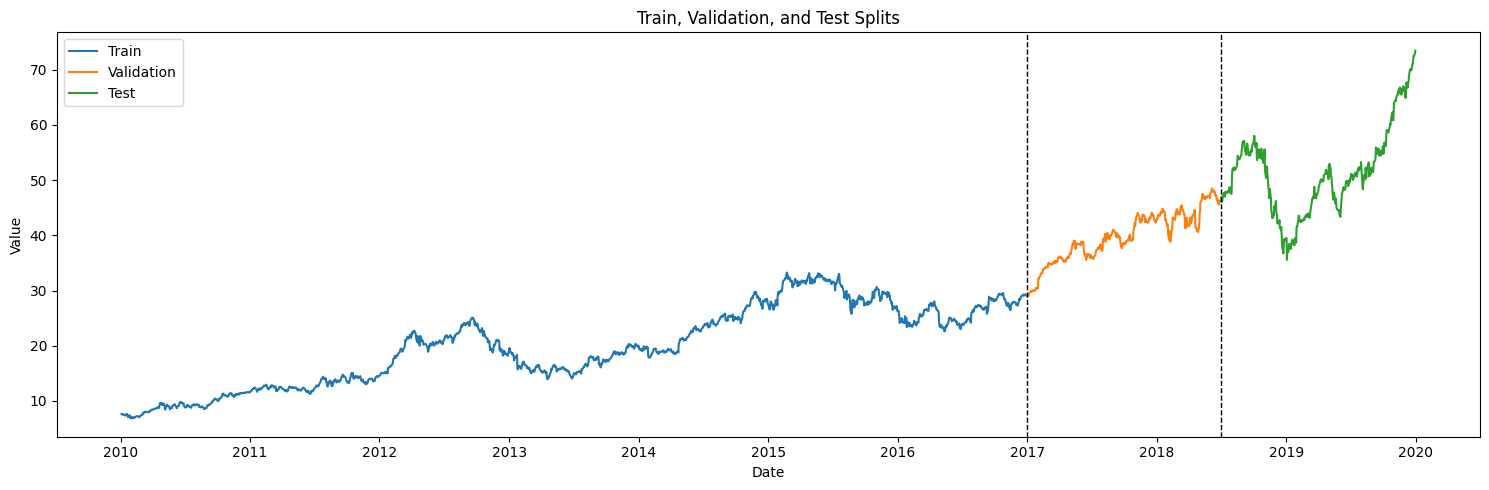


Applied Z-score scaling: mean=19.8455, std=7.0814

Train set sequences:
X_seq shape: (1701, 60)
y_seq shape: (1701, 1)
X_tf shape: (1701, 60, 5)

Validation set sequences:
X_seq shape: (317, 60)
y_seq shape: (317, 1)
X_tf shape: (317, 60, 5)

Test set sequences:
X_seq shape: (318, 60)
y_seq shape: (318, 1)
X_tf shape: (318, 60, 5)

Dataset shapes:
Concatenated Mode: X + X_tf
Train - X: torch.Size([1701, 60, 6]), y: torch.Size([1701, 1])
Validation - X: torch.Size([317, 60, 6]), y: torch.Size([317, 1])
Test - X: torch.Size([318, 60, 6]), y: torch.Size([318, 1])

Train Batch - X: torch.Size([64, 60, 6]), y: torch.Size([64, 1])

Scaling Parameters:
mean: 19.845500734297815
std: 7.0813839362400985

Split Date Ranges (Raw):
Train: (Timestamp('2010-01-04 00:00:00'), Timestamp('2016-12-29 00:00:00'))
Validation: (Timestamp('2016-12-30 00:00:00'), Timestamp('2018-06-29 00:00:00'))
Test: (Timestamp('2018-07-02 00:00:00'), Timestamp('2019-12-31 00:00:00'))

Split Date Ranges (Sequence):
Train: 

In [6]:
# Initialize the preprocessor
preprocessor = TimeSeriesPreprocessor(
    df=df,
    target_col='Value',
    time_features=['quarter', 'month', 'weekofyear', 'dayofweek', 'dayofyear'],
    split_proportions=(0.7, 0.15, 0.15),
    scaling_method='zscore',
    window=60,
    horizon=1,
    split_overlap=False,
    batch_size=64,
    train_shuffle=True,
    concat_time_features=True
)

# Run the preprocessing pipeline
data_loaders, scaling_params, split_dates = preprocessor.process()

# Access the DataLoaders
train_loader = data_loaders['train']
val_loader = data_loaders['validation']
test_loader = data_loaders['test']

In [7]:
# Extract the test set y
test_y = test_loader.dataset.y
print(f"Test Set y shape: {test_y.shape}")

# Extract the test set start and end dates
test_dates = split_dates['sequence']['test']
print(f"Test Set Start & End Dates: {test_dates}")

# Extract the test set data
test_df = df.loc[test_dates[0]:test_dates[1]]
print(f"\nTest Set DataFrame:\n{test_df}")

# Extract the test set dates
test_df_dates = test_df.index
print(f"\nTest Set Dates:\n{test_df_dates}")

Test Set y shape: torch.Size([318, 1])
Test Set Start & End Dates: (Timestamp('2018-09-26 00:00:00'), Timestamp('2019-12-31 00:00:00'))

Test Set DataFrame:
                Value
Date                 
2018-09-26  55.105000
2018-09-27  56.237499
2018-09-28  56.435001
2018-10-01  56.814999
2018-10-02  57.320000
...               ...
2019-12-24  71.067497
2019-12-26  72.477501
2019-12-27  72.449997
2019-12-30  72.879997
2019-12-31  73.412498

[318 rows x 1 columns]

Test Set Dates:
DatetimeIndex(['2018-09-26', '2018-09-27', '2018-09-28', '2018-10-01',
               '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05',
               '2018-10-08', '2018-10-09',
               ...
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='Date', length=318, freq=None)


In [8]:
# Examine a training batch
# X: (batch, window, features)
# y: (batch, horizon)
# X_tf (if present): (batch, window, features)
try:
    for X, y in train_loader:
        print(f"X shape: {X.shape}")
        print(f"y shape: {y.shape}")
        break
except:
    for X, y, X_tf in train_loader:
        print(f"X shape: {X.shape}")
        print(f"y shape: {y.shape}")
        print(f"X_tf shape: {X_tf.shape}")
        break

X shape: torch.Size([64, 60, 6])
y shape: torch.Size([64, 1])


In [9]:
# View the values in a single batch
try:
    for X, y in train_loader:
        print(f"X values: {X}")
        print(f"y values: {y}")
        break
except:
    for X, y, X_tf in train_loader:
        print(f"X values: {X}")
        print(f"y values: {y}")
        print(f"X_tf values: {X_tf}")
        break

X values: tensor([[[-3.5028e-01,  3.0000e+00,  9.0000e+00,  3.9000e+01,  4.0000e+00,
           2.6900e+02],
         [-3.6779e-01,  3.0000e+00,  9.0000e+00,  3.9000e+01,  5.0000e+00,
           2.7000e+02],
         [-3.9805e-01,  3.0000e+00,  9.0000e+00,  4.0000e+01,  1.0000e+00,
           2.7300e+02],
         ...,
         [-3.4498e-03,  4.0000e+00,  1.2000e+01,  5.1000e+01,  2.0000e+00,
           3.5100e+02],
         [-2.4733e-02,  4.0000e+00,  1.2000e+01,  5.1000e+01,  3.0000e+00,
           3.5200e+02],
         [-5.6557e-02,  4.0000e+00,  1.2000e+01,  5.1000e+01,  4.0000e+00,
           3.5300e+02]],

        [[-1.0069e+00,  3.0000e+00,  8.0000e+00,  3.3000e+01,  5.0000e+00,
           2.3100e+02],
         [-1.0048e+00,  3.0000e+00,  8.0000e+00,  3.4000e+01,  1.0000e+00,
           2.3400e+02],
         [-9.1827e-01,  3.0000e+00,  8.0000e+00,  3.4000e+01,  2.0000e+00,
           2.3500e+02],
         ...,
         [-8.0893e-01,  4.0000e+00,  1.1000e+01,  4.5000e+01,  3.0000

In [10]:
print(f"Validation DataLoader has {len(val_loader)} batches.")
print(f"Validation DataLoader contains {len(val_loader.dataset)} samples.")

Validation DataLoader has 5 batches.
Validation DataLoader contains 317 samples.


# Model Definition

From: https://github.com/microsoft/SeqSNN

## Encodings

In [11]:
def generate_ones_and_minus_ones_matrix(rows: int, cols: int) -> torch.FloatTensor:
    """
    Generates a binary matrix of shape (rows, cols) where each element is either 1 or -1.

    Args:
        rows (int): Number of rows in the matrix.
        cols (int): Number of columns in the matrix.

    Returns:
        torch.FloatTensor: A matrix filled with 1s and -1s.
    """
    random_matrix = torch.randint(0, 2, (rows, cols))
    binary_matrix = torch.where(
        random_matrix == 0,
        -1 * torch.ones_like(random_matrix),
        torch.ones_like(random_matrix),
    )
    return binary_matrix.float()

In [12]:
class RandomPE(nn.Module):
    """
    Random Positional Encoding module that injects positional information
    into the input tensor either by concatenation or addition.

    Args:
        d_model (int): Dimension of the input embeddings.
        pe_mode (str, optional): Mode of positional encoding ('concat' or 'add'). Defaults to "concat".
        num_pe_neuron (int, optional): Number of neurons for positional encoding when using 'concat' mode. Defaults to 10.
        neuron_pe_scale (float, optional): Scaling factor for neuron-based positional encoding. Defaults to 1000.0.
        dropout (float, optional): Dropout probability. Defaults to 0.1.
        num_steps (int, optional): Number of steps for neuron simulation. Defaults to 4.
    """

    def __init__(
        self,
        d_model: int,
        pe_mode: str = "concat",
        num_pe_neuron: int = 10,
        neuron_pe_scale: float = 1000.0,
        dropout: float = 0.1,
        num_steps: int = 4,
    ):
        super().__init__()
        self.max_len = 5000  # Maximum sequence length
        self.pe_mode = pe_mode
        self.neuron_pe_scale = neuron_pe_scale
        self.dropout = nn.Dropout(p=dropout)

        # Determine the number of positional encoding neurons based on mode
        if self.pe_mode == "concat":
            self.num_pe_neuron = copy.deepcopy(num_pe_neuron)
        elif self.pe_mode == "add":
            self.num_pe_neuron = copy.deepcopy(d_model)
        else:
            raise ValueError(f"Unsupported pe_mode: {pe_mode}")

        # Generate the positional encoding matrix
        pe = generate_ones_and_minus_ones_matrix(
            self.max_len, self.num_pe_neuron
        )  # Shape: (MaxL, Neur)
        pe = pe.unsqueeze(0).transpose(0, 1)  # Shape: (MaxL, 1, Neur)
        print("pe.shape: ", pe.shape)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass to apply positional encoding to the input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (T, B, L, D).

        Returns:
            torch.Tensor: Output tensor with positional encoding applied, shape (T, B, L, D').
        """
        T, B, L, D = x.shape
        x = x.permute(1, 0, 2, 3)  # Shape: (B, T, L, D)
        x = x.flatten(1, 2)  # Shape: (B, TL, D)

        if self.pe_mode == "concat":
            # tmp: (TL, 1, Neur) -> (TL, B, Neur) -> (B, TL, Neur)
            tmp = self.pe[: x.size(-2), :].repeat(1, B, 1).transpose(0, 1)  # Shape: (B, TL, Neur)
            x = torch.concat([x, tmp], dim=-1)  # Shape: (B, TL, D + Neur)
        elif self.pe_mode == "add":
            # (B, TL, D) + (1, TL, Neur)
            x = x + self.pe[: x.size(-2), :].transpose(0, 1)  # Shape: (B, TL, D)
        else:
            raise ValueError(f"Unsupported pe_mode: {self.pe_mode}")

        # Reshape dimensions
        x = x.transpose(0, 1)  # Shape: (TL, B, D')
        x = x.reshape(T, L, B, -1)  # Shape: (T, L, B, D')
        x = x.permute(0, 2, 1, 3)  # Shape: (T, B, L, D')
        return self.dropout(x)

In [13]:
class NeuronPE(nn.Module):
    """
    Neuron-based Positional Encoding module that uses spiking neurons
    to generate positional encodings either by concatenation or addition.

    Args:
        d_model (int): Dimension of the input embeddings.
        pe_mode (str, optional): Mode of positional encoding ('concat' or 'add'). Defaults to "concat".
        num_pe_neuron (int, optional): Number of neurons for positional encoding when using 'concat' mode. Defaults to 10.
        neuron_pe_scale (float, optional): Scaling factor for neuron activation thresholds. Defaults to 10000.0.
        dropout (float, optional): Dropout probability. Defaults to 0.1.
        num_steps (int, optional): Number of steps for neuron simulation. Defaults to 4.
    """

    def __init__(
        self,
        d_model: int,
        pe_mode: str = "concat",
        num_pe_neuron: int = 10,
        neuron_pe_scale: float = 10000.0,
        dropout: float = 0.1,
        num_steps: int = 4,
    ):
        super().__init__()
        self.max_len = 50000  # Maximum sequence length
        self.pe_mode = pe_mode
        self.neuron_pe_scale = neuron_pe_scale
        self.dropout = nn.Dropout(p=dropout)

        # Determine the number of positional encoding neurons based on mode
        if self.pe_mode == "concat":
            self.num_pe_neuron = copy.deepcopy(num_pe_neuron)
        elif self.pe_mode == "add":
            self.num_pe_neuron = copy.deepcopy(d_model)
        else:
            raise ValueError(f"Unsupported pe_mode: {pe_mode}")

        # Initialize positional encoding using Heaviside step function on sine and cosine
        pe = torch.zeros(self.max_len, self.num_pe_neuron)  # Shape: (MaxL, Neur)
        position = torch.arange(0, self.max_len, dtype=torch.float).unsqueeze(
            1
        )  # Shape: (MaxL, 1)
        div_term = torch.exp(
            torch.arange(0, self.num_pe_neuron, 2).float()
            * (-math.log(neuron_pe_scale) / self.num_pe_neuron)
        )
        div_term_single = torch.exp(
            torch.arange(0, self.num_pe_neuron - 1, 2).float()
            * (-math.log(neuron_pe_scale) / self.num_pe_neuron)
        )
        pe[:, 0::2] = torch.heaviside(
            torch.sin(position * div_term) - 0.8, torch.tensor([1.0])
        )
        pe[:, 1::2] = torch.heaviside(
            torch.cos(position * div_term_single) - 0.8, torch.tensor([1.0])
        )
        pe = pe.unsqueeze(0).transpose(0, 1)  # Shape: (MaxL, 1, Neur)
        print("pe.shape: ", pe.shape)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass to apply neuron-based positional encoding to the input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (T, B, L, D).

        Returns:
            torch.Tensor: Output tensor with positional encoding applied, shape (T, B, L, D').
        """
        T, B, L, D = x.shape
        x = x.permute(1, 0, 2, 3)  # Shape: (B, T, L, D)
        x = x.flatten(1, 2)  # Shape: (B, TL, D)

        if self.pe_mode == "concat":
            # tmp: (TL, 1, Neur) -> (TL, B, Neur) -> (B, TL, Neur)
            tmp = self.pe[: x.size(-2), :].repeat(1, B, 1).transpose(0, 1)
            x = torch.concat([x, tmp], dim=-1)  # Shape: (B, TL, D + Neur)
        elif self.pe_mode == "add":
            # (B, TL, D) + (1, TL, Neur)
            x = x + self.pe[: x.size(-2), :].transpose(0, 1)  # Shape: (B, TL, D)
        else:
            raise ValueError(f"Unsupported pe_mode: {self.pe_mode}")

        # Reshape dimensions
        x = x.transpose(0, 1)  # Shape: (TL, B, D')
        x = x.reshape(T, L, B, -1)  # Shape: (T, L, B, D')
        x = x.permute(0, 2, 1, 3)  # Shape: (T, B, L, D')
        return self.dropout(x)

In [14]:
class StaticPE(nn.Module):
    """
    Static Positional Encoding module that injects fixed sine and cosine
    positional information into the input tensor.

    Args:
        d_model (int): Dimension of the input embeddings.
        dropout (float, optional): Dropout probability. Defaults to 0.1.
        max_len (int, optional): Maximum sequence length. Defaults to 5000.
    """

    def __init__(
        self,
        d_model: int,
        dropout: float = 0.1,
        max_len: int = 5000
    ):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Initialize positional encoding using sine and cosine functions
        pe = torch.zeros(max_len, d_model)  # Shape: (MaxL, D)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # Shape: (MaxL, 1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        div_term_single = torch.exp(
            torch.arange(0, d_model - 1, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term_single)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass to apply static positional encoding to the input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (L, TB, D).

        Returns:
            torch.Tensor: Output tensor with positional encoding applied, shape (L, TB, D).
        """
        # x: (L, TB, D)
        x = x + self.pe[: x.size(0), :]
        x = self.dropout(x)
        return x

In [15]:
class ConvPE(nn.Module):
    """
    Convolutional Positional Encoding module that applies a convolutional
    layer followed by a spiking LIF neuron to generate positional encodings.

    Args:
        d_model (int): Dimension of the input embeddings.
        dropout (float, optional): Dropout probability. Defaults to 0.1.
        max_len (int, optional): Maximum sequence length. Defaults to 5000.
        num_steps (int, optional): Number of simulation steps for the LIF neuron. Defaults to 4.
    """

    def __init__(
        self,
        d_model: int,
        dropout: float = 0.1,
        max_len: int = 5000,
        num_steps: int = 4
    ):
        super().__init__()
        self.T = num_steps
        self.rpe_conv = nn.Conv1d(
            d_model,
            d_model,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        self.rpe_bn = nn.BatchNorm1d(d_model)
        self.rpe_lif = neuron.LIFNode(
            step_mode="m",
            detach_reset=True,
            surrogate_function=surrogate.ATan(),
            v_threshold=1.0,
        )
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass to apply convolutional positional encoding to the input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (L, TB, D).

        Returns:
            torch.Tensor: Output tensor with positional encoding applied, shape (L, TB, D).
        """
        # x: (L, TB, D)
        L, TB, D = x.shape
        x_feat = x.permute(1, 2, 0)  # Shape: (TB, D, L)
        x_feat = self.rpe_conv(x_feat)  # Shape: (TB, D, L)
        x_feat = (
            self.rpe_bn(x_feat).reshape(self.T, int(TB / self.T), D, L).contiguous()
        )  # Shape: (T, B, D, L)
        x_feat = self.rpe_lif(x_feat)
        x_feat = x_feat.flatten(0, 1)  # Shape: (TB, D, L)
        x_feat = self.dropout(x_feat)  # Shape: (TB, D, L)
        x_feat = x_feat.permute(2, 0, 1)  # Shape: (L, TB, D)
        x = x + x_feat
        return x

In [16]:
class PositionEmbedding(nn.Module):
    """
    Position Embedding module that supports various types of positional encodings,
    including learnable, static, convolutional, neuron-based, and random encodings.

    Args:
        input_size (int): Dimension of the input embeddings.
        pe_type (str): Type of positional encoding ('learn', 'static', 'conv', 'neuron', 'random', 'none').
        max_len (int, optional): Maximum sequence length. Defaults to 5000.
        pe_mode (str, optional): Mode of positional encoding ('concat' or 'add'). Defaults to "add".
        num_pe_neuron (int, optional): Number of neurons for positional encoding when applicable. Defaults to 10.
        neuron_pe_scale (float, optional): Scaling factor for neuron activation thresholds when applicable. Defaults to 1000.0.
        dropout (float, optional): Dropout probability. Defaults to 0.1.
        num_steps (int, optional): Number of simulation steps for neuron-based encoding. Defaults to 4.
    """

    def __init__(
        self,
        input_size: int,
        pe_type: str,
        max_len: int = 5000,
        pe_mode: str = "add",
        num_pe_neuron: int = 10,
        neuron_pe_scale: float = 1000.0,
        dropout: float = 0.1,
        num_steps: int = 4,
    ):
        super().__init__()
        self.emb_type = pe_type
        if pe_type in ["learn", "none"]:
            self.emb = nn.Embedding(max_len, input_size)
        elif pe_type == "conv":
            self.emb = ConvPE(
                d_model=input_size,
                max_len=max_len,
                dropout=dropout,
                num_steps=num_steps,
            )
        elif pe_type == "static":
            self.emb = StaticPE(
                d_model=input_size,
                max_len=max_len,
                dropout=dropout
            )
        elif pe_type == "neuron":
            self.emb = NeuronPE(
                d_model=input_size,
                pe_mode=pe_mode,
                num_pe_neuron=num_pe_neuron,
                neuron_pe_scale=neuron_pe_scale,
                dropout=dropout,
                num_steps=num_steps,
            )
        elif pe_type == "random":
            self.emb = RandomPE(
                d_model=input_size,
                pe_mode=pe_mode,
                num_pe_neuron=num_pe_neuron,
                neuron_pe_scale=neuron_pe_scale,
                dropout=dropout,
                num_steps=num_steps,
            )
        else:
            raise ValueError("Unknown embedding type: {}".format(pe_type))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass to apply the selected positional embedding to the input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (T, B, L, D).

        Returns:
            torch.Tensor: Output tensor with positional encoding applied, shape (T, B, L, D').
        """
        if self.emb_type == "learn":
            # T, B, L, D = x.shape # x: T, B, L, D
            # x = x.flatten(0, 1) # TB, L, D
            tmp = torch.arange(
                end=x.size()[1], device=x.device
            )
            embedding = self.emb(tmp)  # Shape: (L, D)
            embedding = embedding.repeat([x.size()[0], 1, 1])  # Shape: (TB, L, D')
            x = x + embedding
            # x = x.reshape(T, B, L, -1)
        elif self.emb_type in ["static", "conv"]:
            T, B, L, D = x.shape  # x: T, B, L, D
            x = x.flatten(0, 1)  # Shape: (TB, L, D)
            x = self.emb(x.transpose(0, 1)).transpose(0, 1)  # Shape: (TB, L, D')
            x = x.reshape(T, B, L, -1)  # Shape: (T, B, L, D')
        elif self.emb_type in ["neuron", "random"]:
            T, B, L, D = x.shape  # x: T, B, L, D
            x = self.emb(x)
            x = x.reshape(T, B, L, -1)
        return x  # Shape: (T, B, L, D')

## Attention

In [17]:
# Constants for the spiking neuron dynamics
tau: float = 2.0  # beta = 1 - 1/tau
backend: str = "torch"
detach_reset: bool = True

In [18]:
class SSA(nn.Module):
    """
    Spiking Self-Attention (SSA) module implementing a multi-head self-attention mechanism
    with spiking neurons.

    Args:
        length (int): Sequence length.
        tau (float): Time constant for LIF neurons.
        common_thr (float): Common threshold for all LIF neurons.
        dim (int): Dimensionality of the input features.
        heads (int, optional): Number of attention heads. Default is 8.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, and value projections. Default is False.
        qk_scale (float, optional): Scaling factor for the query and key projections. Default is 0.25.
    """

    def __init__(
        self,
        length: int,
        tau: float,
        common_thr: float,
        dim: int,
        heads: int = 8,
        qkv_bias: bool = False,
        qk_scale: float = 0.25,
    ):
        super().__init__()
        assert dim % heads == 0, f"dim {dim} should be divisible by num_heads {heads}."

        self.dim: int = dim
        self.heads: int = heads
        self.qk_scale: float = qk_scale

        # Query projection components
        self.q_m = nn.Linear(dim, dim)
        self.q_bn = nn.BatchNorm1d(dim)
        self.q_lif = neuron.LIFNode(
            tau=tau,
            step_mode="m",
            detach_reset=detach_reset,
            surrogate_function=surrogate.ATan(),
            v_threshold=common_thr,
            backend=backend,
        )

        # Key projection components
        self.k_m = nn.Linear(dim, dim)
        self.k_bn = nn.BatchNorm1d(dim)
        self.k_lif = neuron.LIFNode(
            tau=tau,
            step_mode="m",
            detach_reset=detach_reset,
            surrogate_function=surrogate.ATan(),
            v_threshold=common_thr,
            backend=backend,
        )

        # Value projection components
        self.v_m = nn.Linear(dim, dim)
        self.v_bn = nn.BatchNorm1d(dim)
        self.v_lif = neuron.LIFNode(
            tau=tau,
            step_mode="m",
            detach_reset=detach_reset,
            surrogate_function=surrogate.ATan(),
            v_threshold=common_thr,
            backend=backend,
        )

        # Attention LIF neuron for processing attention outputs
        self.attn_lif = neuron.LIFNode(
            tau=tau,
            step_mode="m",
            detach_reset=detach_reset,
            surrogate_function=surrogate.ATan(),
            v_threshold=common_thr / 2,
            backend=backend,
        )

        # Final projection components
        self.last_m = nn.Linear(dim, dim)
        self.last_bn = nn.BatchNorm1d(dim)
        self.last_lif = neuron.LIFNode(
            tau=tau,
            step_mode="m",
            detach_reset=detach_reset,
            surrogate_function=surrogate.ATan(),
            v_threshold=common_thr,
            backend=backend,
        )

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the SSA module.
        """
        # x = x.transpose(0, 1)
        T, B, L, D = x.shape
        x_for_qkv = x.flatten(0, 1)  # Shape: (TB, L, D)

        # Process query projection
        q_m_out = self.q_m(x_for_qkv)  # (TB, L, D)
        q_m_out = (
            self.q_bn(q_m_out.transpose(-1, -2))
            .transpose(-1, -2)
            .reshape(T, B, L, D)
            .contiguous()
        )
        q_m_out = self.q_lif(q_m_out)
        q = (
            q_m_out.reshape(T, B, L, self.heads, D // self.heads)
            .permute(0, 1, 3, 2, 4)
            .contiguous()
        )

        # Process key projection
        k_m_out = self.k_m(x_for_qkv)
        k_m_out = (
            self.k_bn(k_m_out.transpose(-1, -2))
            .transpose(-1, -2)
            .reshape(T, B, L, D)
            .contiguous()
        )
        k_m_out = self.k_lif(k_m_out)
        k = (
            k_m_out.reshape(T, B, L, self.heads, D // self.heads)
            .permute(0, 1, 3, 2, 4)
            .contiguous()
        )

        # Process value projection
        v_m_out = self.v_m(x_for_qkv)
        v_m_out = (
            self.v_bn(v_m_out.transpose(-1, -2))
            .transpose(-1, -2)
            .reshape(T, B, L, D)
            .contiguous()
        )
        v_m_out = self.v_lif(v_m_out)
        v = (
            v_m_out.reshape(T, B, L, self.heads, D // self.heads)
            .permute(0, 1, 3, 2, 4)
            .contiguous()
        )

        # Compute scaled dot-product attention
        attn = (q @ k.transpose(-2, -1)) * self.qk_scale
        x = attn @ v  # x_shape: (T * B * heads * L * D//heads)

        # Reshape and apply LIF neuron to attention output
        x = x.transpose(2, 3).reshape(T, B, L, D).contiguous()
        x = self.attn_lif(x)

        # Final processing
        x = x.flatten(0, 1)
        x = self.last_m(x)
        x = self.last_bn(x.transpose(-1, -2)).transpose(-1, -2)
        x = self.last_lif(x.reshape(T, B, L, D).contiguous())
        return x

In [19]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron (MLP) module with spiking neurons.

    Args:
        length (int): Sequence length.
        tau (float): Time constant for LIF neurons.
        common_thr (float): Common threshold for all LIF neurons.
        in_features (int): Number of input features.
        hidden_features (Optional[int], optional): Number of hidden units.
        out_features (Optional[int], optional): Number of output features.
    """

    def __init__(
        self,
        length: int,
        tau: float,
        common_thr: float,
        in_features: int,
        hidden_features: Optional[int] = None,
        out_features: Optional[int] = None,
    ):
        super().__init__()
        # self.length = length
        out_features = out_features or in_features
        self.in_features: int = in_features
        self.hidden_features: int = hidden_features
        self.out_features: int = out_features

        # First layer components
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.lif1 = neuron.LIFNode(
            tau=tau,
            step_mode="m",
            detach_reset=detach_reset,
            surrogate_function=surrogate.ATan(),
            v_threshold=common_thr,
            backend=backend,
        )

        # Second layer components
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.bn2 = nn.BatchNorm1d(out_features)
        self.lif2 = neuron.LIFNode(
            tau=tau,
            step_mode="m",
            detach_reset=detach_reset,
            surrogate_function=surrogate.ATan(),
            v_threshold=common_thr,
            backend=backend,
        )

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the MLP module.
        """
        T, B, L, D = x.shape

        # First transformation
        x = x.flatten(0, 1)  # Shape: (TB, L, D)
        x = self.fc1(x)  # Shape: (TB, L, H)
        x = (
            self.bn1(x.transpose(-1, -2))
            .transpose(-1, -2)
            .reshape(T, B, L, self.hidden_features)
            .contiguous()
        )
        x = self.lif1(x)  # Apply LIF neuron

        # Second transformation
        x = x.flatten(0, 1)  # Shape: (TB, L, H)
        x = self.fc2(x)  # Shape: (TB, L, D)
        x = (
            self.bn2(x.transpose(-1, -2))
            .transpose(-1, -2)
            .reshape(T, B, L, D)
            .contiguous()
        )
        x = self.lif2(x)  # Apply LIF neuron
        return x

In [20]:
class Block(nn.Module):
    """
    Transformer Block composed of a Spiking Self-Attention (SSA) module and a Multi-Layer Perceptron (MLP) module.

    Args:
        length (int): Sequence length.
        tau (float): Time constant for LIF neurons.
        common_thr (float): Common threshold for all LIF neurons.
        dim (int): Dimensionality of the input features.
        d_ff (int): Dimensionality of the hidden layer in the MLP.
        heads (int, optional): Number of attention heads. Default is 8.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, and value projections. Default is False.
        qk_scale (float, optional): Scaling factor for the query and key projections. Default is 0.125.
    """

    def __init__(
        self,
        length: int,
        tau: float,
        common_thr: float,
        dim: int,
        d_ff: int,
        heads: int = 8,
        qkv_bias: bool = False,
        qk_scale: float = 0.125,
    ):
        super().__init__()
        self.attn = SSA(
            length=length,
            tau=tau,
            common_thr=common_thr,
            dim=dim,
            heads=heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
        )
        self.mlp = MLP(
            length=length,
            tau=tau,
            common_thr=common_thr,
            in_features=dim,
            hidden_features=d_ff,
        )

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the Transformer Block.
        """
        x = x + self.attn(x)
        x = x + self.mlp(x)
        return x

## Backbone

In [21]:
class ConvEncoder(nn.Module):
    """
    Convolutional Encoder for processing input sequences into spike-encoded feature maps.

    This module applies a 2D convolution followed by batch normalization and a Leaky Integrate-and-Fire (LIF) neuron
    to encode input tensors into spike trains suitable for spiking neural networks.

    Args:
        output_size (int): Number of output channels for the convolutional layer.
        kernel_size (int, optional): Size of the convolutional kernel. Default is 3.
    """

    def __init__(
        self,
        output_size: int,
        kernel_size: int = 3
    ):
        super().__init__()

        # Sequential convolutional layer with batch normalization
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=output_size,
                kernel_size=(1, kernel_size),
                stride=1,
                padding=(0, kernel_size // 2),
            ),
            nn.BatchNorm2d(output_size),
        )

        # LIF neuron for spike generation
        self.lif = neuron.LIFNode(
            tau=tau,
            step_mode="m",
            detach_reset=detach_reset,
            surrogate_function=surrogate.ATan(),
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """
        Forward pass to encode input tensor into spike trains.

        Args:
            inputs (torch.Tensor): Input tensor of shape (B, L, D),
                                   where B is batch size, L is sequence length, and D is feature dimension.

        Returns:
            torch.Tensor: Spike-encoded tensor of shape (T, B, D, L),
                          where T is the number of time steps.
        """
        # inputs: (B, L, D)
        inputs = inputs.permute(0, 2, 1).unsqueeze(1)  # Shape: (B, 1, D, L)
        enc = self.encoder(inputs)  # Shape: (B, T, D, L)
        enc = enc.permute(1, 0, 2, 3)  # Shape: (T, B, D, L)
        spks = self.lif(enc)  # Shape: (T, B, D, L)
        return spks

In [22]:
class Spikformer(nn.Module):
    """
    Spikformer: A Spiking Transformer-based Neural Network for sequential data.

    This model integrates spiking neural network components with transformer-like attention mechanisms.
    It encodes input sequences into spike trains, applies positional encoding, and processes them through
    multiple attention blocks to produce output representations.

    Args:
        dim (int): Dimensionality of the model's hidden representations.
        d_ff (Optional[int], optional): Dimensionality of the feed-forward network.
        num_pe_neuron (int, optional): Number of neurons used for positional encoding. Default is 10.
        pe_type (str, optional): Type of positional encoding. Options: "none", "neuron", "random". Default is "none".
        pe_mode (str, optional): Mode of positional encoding application. Options: "add", "concat". Default is "concat".
        neuron_pe_scale (float, optional): Scaling factor for neuron-based positional encoding. Default is 1000.0.
        depths (int, optional): Number of transformer blocks. Default is 2.
        common_thr (float, optional): Common threshold for LIF neurons. Default is 1.0.
        max_length (int, optional): Maximum sequence length. Default is 5000.
        num_steps (int, optional): Number of time steps for spike encoding. Default is 4.
        heads (int, optional): Number of attention heads. Default is 8.
        qkv_bias (bool, optional): Whether to include bias terms in QKV projections. Default is False.
        qk_scale (float, optional): Scaling factor for QK attention scores. Default is 0.125.
        input_size (Optional[int], optional): Dimensionality of the input features.
    """

    def __init__(
        self,
        dim: int,
        d_ff: Optional[int] = None,
        num_pe_neuron: int = 10,
        pe_type: str = "none",
        pe_mode: str = "concat",  # "add" or "concat"
        neuron_pe_scale: float = 1000.0,  # 100.0 or 1000.0 or 10000.0
        depths: int = 2,
        common_thr: float = 1.0,
        max_length: int = 5000,
        num_steps: int = 4,
        heads: int = 8,
        qkv_bias: bool = False,
        qk_scale: float = 0.125,
        input_size: Optional[int] = None
    ):
        super().__init__()
        self.dim: int = dim
        self.d_ff: int = d_ff or dim * 4
        self.T: int = num_steps
        self.depths: int = depths
        self.pe_type: str = pe_type
        self.pe_mode: str = pe_mode
        self.num_pe_neuron: int = num_pe_neuron

        # Spike encoder for temporal encoding of input sequences
        self.temporal_encoder = ConvEncoder(num_steps)

        # Positional encoding module
        self.pe = PositionEmbedding(
            pe_type=pe_type,
            pe_mode=pe_mode,
            neuron_pe_scale=neuron_pe_scale,
            input_size=input_size,
            max_len=max_length,
            num_pe_neuron=self.num_pe_neuron,
            dropout=0.1,
            num_steps=num_steps
        )

        # Linear encoder
        if (self.pe_type == "neuron" and self.pe_mode == "concat") or (
            self.pe_type == "random" and self.pe_mode == "concat"
        ):
            self.encoder = nn.Linear(input_size + num_pe_neuron, dim)
        else:
            self.encoder = nn.Linear(input_size, dim)

        # LIF neuron layer
        self.init_lif = neuron.LIFNode(
            tau=tau,
            step_mode="m",
            detach_reset=detach_reset,
            surrogate_function=surrogate.ATan(),
            v_threshold=common_thr,
            backend=backend,
        )

        # Attention blocks
        self.blocks = nn.ModuleList(
            [
                Block(
                    length=max_length,
                    tau=tau,
                    common_thr=common_thr,
                    dim=dim,
                    d_ff=self.d_ff,
                    heads=heads,
                    qkv_bias=qkv_bias,
                    qk_scale=qk_scale,
                )
                for _ in range(depths)
            ]
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        """
        Initialize weights of the model.

        Args:
            m (nn.Module): Module to initialize.
        """
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0.0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.weight, 1.0)
            nn.init.constant_(m.bias, 0.0)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the Spikformer model.

        Args:
            x (torch.Tensor): Input tensor of shape (B, L, C),
                              where B is batch size, L is sequence length, and C is input feature dimension.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]:
                - Output tensor of shape (B, L, D), where D is the model's hidden dimension.
                - Mean-pooled output tensor of shape (B, D).
        """
        # Reset the state of spiking neurons
        functional.reset_net(self)

        # Encode temporal information into spike trains
        x = self.temporal_encoder(x)  # Shape: (B, L, C) -> (T, B, C, L)
        x = x.transpose(-2, -1)  # Shape: (T, B, L, C)

        # Apply positional encoding
        if self.pe_type != "none":
            x = self.pe(x)  # Shape: (T, B, L, C')

        T, B, L, D = x.shape

        # Encode and apply LIF neuron layer
        x = self.encoder(x.flatten(0, 1)).reshape(T, B, L, -1)  # Shape: (T, B, L, D)
        x = self.init_lif(x)

        # Pass through attention blocks
        for blk in self.blocks:
            x = blk(x)  # Shape: (T, B, L, D)
        out1 = x.mean(0)  # Shape: (B, L, D)
        out2 = out1.mean(dim=1)  # Shape: (B, D)
        return out1, out2

    @property
    def output_size(self) -> int:
        """
        Get the output size of the model.

        Returns:
            int: Dimensionality of the model's output.
        """
        return self.dim

    @property
    def hidden_size(self) -> int:
        """
        Get the hidden size of the model.

        Returns:
            int: Dimensionality of the model's hidden representations.
        """
        return self.dim

## Interface

In [23]:
class SpikformerModel(nn.Module):
    """
    High-level container that instantiates a Spikformer network and handles:
      - Normalization strategy
      - Aggregation of outputs
      - Final output projection (e.g., for forecasting)

    Args:
        dim (int): Dimensionality of the model's hidden representations.
        d_ff (Optional[int], optional): Feed-forward dimensionality.
        num_pe_neuron (int, optional): Number of neurons used for neuron-based positional encoding. Default is 10.
        pe_type (str, optional): Type of positional encoding.
        pe_mode (str, optional): How positional encoding is applied: "add" or "concat". Default is "concat".
        neuron_pe_scale (float, optional): Scale for neuron-based positional encoding. Default is 1000.0.
        depths (int, optional): Number of transformer blocks. Default is 2.
        common_thr (float, optional): Threshold for LIF neurons. Default is 1.0.
        max_length (int, optional): Maximum sequence length. Default is 5000.
        num_steps (int, optional): Number of time steps for spike encoding. Default is 4.
        heads (int, optional): Number of attention heads. Default is 8.
        qkv_bias (bool, optional): Whether to include bias terms in QKV projections. Default is False.
        qk_scale (float, optional): Scaling factor for QK attention scores. Default is 0.125.
        input_size (Optional[int], optional): Dimensionality of the input features.
        aggregate (bool, optional): If True, uses mean-pooled representation as output. Otherwise uses full sequence output. Default is True.
        normalize (bool, optional): If True, normalizes input features. Default is True.
        features_to_normalize (Optional[List[int]], optional): List of feature indices to normalize. If "all", normalize all. Default is "all".
        target_index (int, optional): Index of the feature to denormalize predictions. Default is 0.
    """

    def __init__(
        self,
        dim: int,
        d_ff: Optional[int] = None,
        num_pe_neuron: int = 10,
        pe_type: str = "none",
        pe_mode: str = "concat",  # "add" or "concat"
        neuron_pe_scale: float = 1000.0,
        depths: int = 2,
        common_thr: float = 1.0,
        max_length: int = 5000,
        num_steps: int = 4,
        heads: int = 8,
        qkv_bias: bool = False,
        qk_scale: float = 0.125,
        input_size: Optional[int] = None,
        aggregate: bool = True,
        normalize: bool = True,
        features_to_normalize: Union[List[int], str] = "all",
        target_index: int = 0
    ):
        super().__init__()
        self.aggregate = aggregate
        self.normalize = normalize
        self.features_to_normalize = features_to_normalize
        self.target_index = target_index

        # Initialize the Spikformer network
        self.network = Spikformer(
            dim=dim,
            d_ff=d_ff,
            num_pe_neuron=num_pe_neuron,
            pe_type=pe_type,
            pe_mode=pe_mode,
            neuron_pe_scale=neuron_pe_scale,
            depths=depths,
            common_thr=common_thr,
            max_length=max_length,
            num_steps=num_steps,
            heads=heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            input_size=input_size
        )

        # Final linear layer to produce a single output value
        self.fc_out = nn.Linear(self.network.output_size, 1)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of SpikformerModel.

        Args:
            inputs (torch.Tensor): Input tensor of shape (B, L, C).

        Returns:
            torch.Tensor: Predictions of shape (B,).
        """
        B, L, C = inputs.shape

        if self.normalize:
            # Determine features to normalize
            if self.features_to_normalize == "all":
                fmask = list(range(C))
            else:
                fmask = self.features_to_normalize

                # Validate feature indices
                if not all(0 <= idx < C for idx in fmask):
                    raise ValueError("Feature indices in 'features_to_normalize' are out of bounds.")

            if fmask:
                # Compute mean and std across the time dimension for selected features
                means = inputs[:, :, fmask].mean(dim=1, keepdim=True).detach()
                inputs[:, :, fmask] = inputs[:, :, fmask] - means

                std = torch.sqrt(
                    torch.var(inputs[:, :, fmask], dim=1, keepdim=True, unbiased=False) + 1e-8
                ).detach()
                inputs[:, :, fmask] = inputs[:, :, fmask] / std

        # Pass through the Spikformer network
        seq_out, emb_outs = self.network(inputs)

        # Assign output based on 'aggregate' flag
        out = emb_outs if self.aggregate else seq_out

        # Apply final linear layer
        preds = self.fc_out(out).squeeze(-1)  # Shape: (B,) or (B, L)

        # De-normalize predictions
        if self.normalize and fmask:
            ti = self.target_index

            if ti in fmask:
                local_idx = fmask.index(ti)
                preds = preds * std[:, 0, local_idx] + means[:, 0, local_idx]
            else:
                raise ValueError(
                    f"Target index {ti} not found in features to normalize."
                )

        return preds

# Model Initialization

In [24]:
def set_seed(seed: int = 42) -> None:
    """
    Set random seeds for reproducibility across various libraries.

    Args:
        seed (int): Seed value to use for random number generation. Defaults to 42.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [25]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [26]:
# Model configuration parameters
dim = 128
d_ff = 512
num_pe_neuron = 40
pe_type = 'neuron'
pe_mode = 'add'
neuron_pe_scale = 10000.0
depths = 2
common_thr = 1.0
max_length = 5000
num_steps = 4
heads = 8
qkv_bias = False
qk_scale = 0.125
input_size = 6
aggregate = True
normalize = True
target_index = 0

In [27]:
set_seed(42)

# Initialize the model
model = SpikformerModel(
    dim=dim,
    d_ff=d_ff,
    num_pe_neuron=num_pe_neuron,
    pe_type=pe_type,
    pe_mode=pe_mode,
    neuron_pe_scale=neuron_pe_scale,
    depths=depths,
    common_thr=common_thr,
    max_length=max_length,
    num_steps=num_steps,
    heads=heads,
    qkv_bias=qkv_bias,
    qk_scale=qk_scale,
    input_size=input_size,
    aggregate=aggregate,
    normalize=normalize,
    features_to_normalize="all",
    target_index=target_index
).to(device)

pe.shape:  torch.Size([50000, 1, 6])


In [28]:
class SMAPELoss(nn.Module):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (sMAPE) between
    predictions and targets.

    For each element:
        sMAPE_i = 2 * |y_pred - y_true| / (|y_pred| + |y_true| + eps)

    Then the mean across all elements in the batch is returned.

    Args:
        eps (float): A small constant to avoid division by zero. Defaults to 1e-8.

    Example:
        >>> criterion = SMAPELoss()
        >>> loss = criterion(y_pred, y_true)
    """

    def __init__(self, eps: float = 1e-8) -> None:
        super(SMAPELoss, self).__init__()
        self.eps = eps

    def forward(
        self,
        y_pred: torch.Tensor,
        y_true: torch.Tensor
    ) -> torch.Tensor:
        """
        Forward pass for SMAPE computation.

        Args:
            y_pred (torch.Tensor): Predicted values.
            y_true (torch.Tensor): Ground truth values.

        Returns:
            torch.Tensor: Scalar SMAPE loss.

        Raises:
            ValueError: If the shapes of y_pred and y_true do not match.
        """
        # Reshape y_pred and y_true to (B, ) if needed
        if y_pred.dim() == 2 and y_pred.size(1) == 1:
            y_pred = y_pred.squeeze(1)
        assert y_pred.dim() == 1, f"y_pred must be 1D after squeezing, got shape {y_pred.shape}"

        if y_true.dim() == 2 and y_true.size(1) == 1:
            y_true = y_true.squeeze(1)
        assert y_true.dim() == 1, f"y_true must be 1D after squeezing, got shape {y_true.shape}"

        if y_pred.shape != y_true.shape:
            raise ValueError

        numerator = torch.abs(y_pred - y_true)
        denominator = torch.abs(y_true) + torch.abs(y_pred) + self.eps
        smape = (2.0 * numerator) / denominator * 100.0

        return smape.mean()

In [29]:
# Define loss function
criterion_name = 'MSE'

if criterion_name == 'MSE':
    criterion = nn.MSELoss()
elif criterion_name == 'sMAPE':
    criterion = SMAPELoss()
elif criterion_name == 'L1':
    criterion = nn.L1Loss()
elif criterion_name == 'SmoothL1':
    criterion = nn.SmoothL1Loss()
elif criterion_name == 'Huber':
    criterion = nn.HuberLoss()
else:
    raise ValueError(f"Unsupported loss function: {criterion_name}")

# Define the optimizer
optimizer_name = 'AdamW'

if optimizer_name == 'AdamW':
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-3,
        weight_decay=0.01
    )
elif optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=1e-3,
        weight_decay=0.01
    )
elif optimizer_name == 'NAdam':
    optimizer = torch.optim.NAdam(
        model.parameters(),
        lr=1e-3,
        weight_decay=0.01
    )
else:
    raise ValueError(f"Unsupported optimizer: {optimizer_name}")

# Model Training

In [30]:
def train_one_epoch(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    loader: DataLoader,
    device: torch.device
) -> float:
    """
    Train the model for one epoch and return the average loss.

    Args:
        model (nn.Module): The Spikformer model or any PyTorch model.
        optimizer (torch.optim.Optimizer): Optimizer object.
        criterion (nn.Module): Loss function (e.g., MSE, sMAPE).
        loader (DataLoader): DataLoader for the training set.
        device (torch.device): The device to run on (CPU or GPU).

    Returns:
        float: The average training loss over the epoch.
    """
    model.train()
    total_loss = 0.0
    sample_count = 0

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        pred = model(X_batch)

        # Reshape pred and y_batch to (B, ) if needed
        if pred.dim() == 2 and pred.size(1) == 1:
            pred = pred.squeeze(1)
        assert pred.dim() == 1, f"pred must be 1D after squeezing, got shape {pred.shape}"

        if y_batch.dim() == 2 and y_batch.size(1) == 1:
            y_batch = y_batch.squeeze(1)
        assert y_batch.dim() == 1, f"y_batch must be 1D after squeezing, got shape {y_batch.shape}"

        if pred.shape != y_batch.shape:
            raise ValueError

        loss = criterion(pred, y_batch)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        sample_count += X_batch.size(0)

    avg_loss = total_loss / sample_count
    return avg_loss

In [31]:
def evaluate(
    model: nn.Module,
    criterion: nn.Module,
    loader: DataLoader,
    device: torch.device
) -> float:
    """
    Evaluate the model on a given dataset (validation or test).

    Args:
        model (nn.Module): The PyTorch model to evaluate.
        criterion (nn.Module): Loss function (e.g., MSE, sMAPE).
        loader (DataLoader): DataLoader for the validation or test set.
        device (torch.device): Device to run on.

    Returns:
        float: The average loss on the dataset.
    """
    model.eval()
    total_loss = 0.0
    sample_count = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            pred = model(X_batch)

            # Reshape pred and y_batch to (B, ) if needed
            if pred.dim() == 2 and pred.size(1) == 1:
                pred = pred.squeeze(1)
            assert pred.dim() == 1, f"pred must be 1D after squeezing, got shape {pred.shape}"

            if y_batch.dim() == 2 and y_batch.size(1) == 1:
                y_batch = y_batch.squeeze(1)
            assert y_batch.dim() == 1, f"y_batch must be 1D after squeezing, got shape {y_batch.shape}"

            if pred.shape != y_batch.shape:
                raise ValueError

            loss = criterion(pred, y_batch)

            total_loss += loss.item() * X_batch.size(0)
            sample_count += X_batch.size(0)

    avg_loss = total_loss / sample_count
    return avg_loss

In [33]:
def run_training(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    epochs: int = 100,
    early_stopping_patience: int = 5,
    lr_scheduler_patience: int = 3,
    lr_scheduler_factor: float = 0.1,
    print_progress: bool = True,
    report_freq: int = 1,
    checkpoint_path: str = 'best_model.pth'
):
    """
    Training loop with early stopping, learning rate scheduling, and checkpointing.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): Training DataLoader.
        val_loader (DataLoader): Validation DataLoader.
        criterion (nn.Module): Loss function (e.g., MSE, sMAPE).
        optimizer (torch.optim.Optimizer): Optimization algorithm.
        device (torch.device): The device for training.
        epochs (int, optional): Maximum number of training epochs. Defaults to 100.
        early_stopping_patience (int, optional): Patience for early stopping. Defaults to 5.
        lr_scheduler_patience (int, optional): Patience for reducing learning rate. Defaults to 3.
        lr_scheduler_factor (float, optional): Factor by which to reduce the learning rate. Defaults to 0.1.
        print_progress (bool, optional): Whether to print progress logs. Defaults to True.
        report_freq (int, optional): Frequency (in epochs) of logging output. Defaults to 1.
        checkpoint_path (str, optional): File path to save the best model weights. Defaults to 'best_model.pth'.

    Returns:
        Tuple[nn.Module, dict, int]:
            - The best model (with weights loaded from the best epoch).
            - A dictionary containing 'train_loss' and 'val_loss' lists.
            - The epoch at which the validation loss was at its minimum.
    """
    # Initialize tracking variables
    best_val_loss = float('inf')
    best_epoch = -1  # Initialize to -1 to indicate no improvement yet
    best_epoch_time = 0.0
    best_epoch_lr = 0.0
    patience_counter = 0

    # Initialize learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=lr_scheduler_factor,
        patience=lr_scheduler_patience,
        min_lr=1e-8
    )

    # Initialize history dictionary to store loss values
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(1, epochs + 1):  # Epoch counting starts from 1
        start_time = time.time()

        # Training phase
        train_loss = train_one_epoch(model, optimizer, criterion, train_loader, device)

        # Validation phase
        val_loss = evaluate(model, criterion, val_loader, device)

        # Current learning rate before scheduler step
        current_lr = optimizer.param_groups[0]['lr']

        # Update learning rate scheduler based on validation loss
        scheduler.step(val_loss)

        # Current learning rate after scheduler step
        updated_lr = optimizer.param_groups[0]['lr']

        # Check if learning rate has been adjusted and log if necessary
        if print_progress and (updated_lr != current_lr):
            print(f"Learning rate adjusted at Epoch {epoch}: {current_lr:.2e} -> {updated_lr:.2e}")

        # Measure elapsed time for the epoch
        elapsed = time.time() - start_time

        # Check for improvement in validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_epoch_time = elapsed
            best_epoch_lr = updated_lr
            torch.save(model.state_dict(), checkpoint_path)  # Save the best model
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increment patience counter

        # Record losses in history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        # Progress reporting
        if print_progress and (epoch == 1 or epoch % report_freq == 0):
            print(f"Epoch {epoch}/{epochs} - "
                  f"Train Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"Time: {elapsed:.2f}s | "
                  f"LR: {updated_lr:.2e}")

        # Early stopping condition
        if patience_counter >= early_stopping_patience:
            if print_progress:
                print(f"Early Stopping triggered at Epoch {epoch}.")
            break

    # Load the best model weights after training completes
    model.load_state_dict(torch.load(checkpoint_path))

    # Final reporting of training results
    if print_progress:
        final_epoch = epoch
        print(f"\nFinal Epoch {final_epoch}/{epochs} - "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Time: {elapsed:.2f}s | "
              f"LR: {updated_lr:.2e}")
        if best_epoch != -1:
            print(f"\nBest Epoch {best_epoch}/{epochs} - "
                  f"Train Loss: {history['train_loss'][best_epoch - 1]:.4f} | "
                  f"Val Loss: {best_val_loss:.4f} | "
                  f"Time: {best_epoch_time:.2f}s | "
                  f"LR: {best_epoch_lr:.2e}")
        else:
            print("No improvement observed during training.")

    return model, history, best_epoch

In [34]:
# Training hyperparameters
epochs = 1000
early_stopping_patience = 20
lr_scheduler_patience = 5
lr_scheduler_factor = 0.1
print_progress = True
report_freq = 1
checkpoint_path = 'best_model.pth'

In [35]:
set_seed(42)

# Train the model
trained_model, history, best_epoch = run_training(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=epochs,
    early_stopping_patience=early_stopping_patience,
    lr_scheduler_patience=lr_scheduler_patience,
    lr_scheduler_factor=lr_scheduler_factor,
    print_progress=print_progress,
    report_freq=report_freq,
    checkpoint_path=checkpoint_path
)

Epoch 1/1000 - Train Loss: 0.0475 | Val Loss: 0.0749 | Time: 8.93s | LR: 1.00e-03
Epoch 2/1000 - Train Loss: 0.0473 | Val Loss: 0.0736 | Time: 1.79s | LR: 1.00e-03
Epoch 3/1000 - Train Loss: 0.0471 | Val Loss: 0.0725 | Time: 1.74s | LR: 1.00e-03
Epoch 4/1000 - Train Loss: 0.0470 | Val Loss: 0.0684 | Time: 1.76s | LR: 1.00e-03
Epoch 5/1000 - Train Loss: 0.0469 | Val Loss: 0.0965 | Time: 1.76s | LR: 1.00e-03
Epoch 6/1000 - Train Loss: 0.0467 | Val Loss: 0.0696 | Time: 1.73s | LR: 1.00e-03
Epoch 7/1000 - Train Loss: 0.0462 | Val Loss: 0.0689 | Time: 1.72s | LR: 1.00e-03
Epoch 8/1000 - Train Loss: 0.0458 | Val Loss: 0.0687 | Time: 1.73s | LR: 1.00e-03
Epoch 9/1000 - Train Loss: 0.0456 | Val Loss: 0.0680 | Time: 1.71s | LR: 1.00e-03
Epoch 10/1000 - Train Loss: 0.0453 | Val Loss: 0.0682 | Time: 1.76s | LR: 1.00e-03
Epoch 11/1000 - Train Loss: 0.0450 | Val Loss: 0.0679 | Time: 1.71s | LR: 1.00e-03
Epoch 12/1000 - Train Loss: 0.0446 | Val Loss: 0.0677 | Time: 1.71s | LR: 1.00e-03
Epoch 13/1000

In [36]:
def plot_training_history(history: dict, x_tick_interval: int = 10) -> None:
    """
    Plot the training and validation loss history with x-ticks at the first epoch
    and then every `x_tick_interval` epochs thereafter.

    Args:
        history (dict): Dictionary containing 'train_loss' and 'val_loss' lists.
        x_tick_interval (int, optional): Interval for x-axis tick labels. Default is 10.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')

    # Generate x-tick positions: always include the first epoch, then every interval-th epoch
    if x_tick_interval > 0:
        # Start with the first epoch
        tick_positions = [1]
        # Add every x_tick_interval-th epoch starting from x_tick_interval
        tick_positions += list(range(x_tick_interval, len(epochs) + 1, x_tick_interval))

        # Ensure the last epoch is included if it is not already
        if tick_positions[-1] != len(epochs):
            tick_positions.append(len(epochs))
    else:
        # If interval is 0 or negative, default to showing all ticks
        tick_positions = epochs

    plt.xticks(tick_positions)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

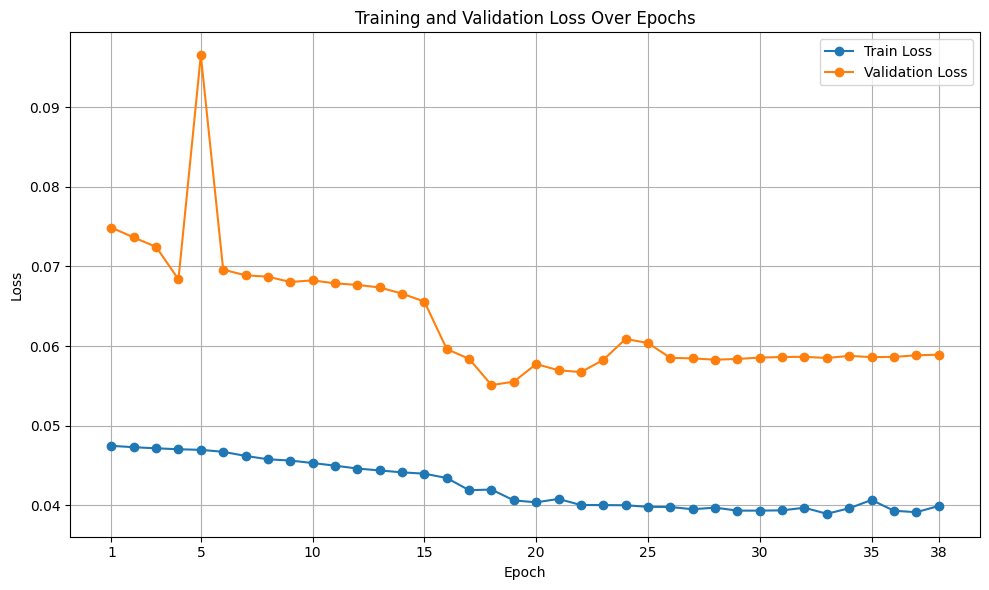

In [37]:
# Plot the training and validation loss history
plot_training_history(history, x_tick_interval=5)

# Model Evaluation

In [38]:
def evaluate_test_set(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
    scaling_params: Dict[str, float],
    epsilon: float = 1e-8,
    aggregate: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Evaluate the model on the test set, returning inverse-transformed
    predictions and truths for final analysis.

    Args:
        model (nn.Module): Trained model.
        loader (DataLoader): Test DataLoader.
        device (torch.device): Compute device.
        scaling_params (Dict[str, float]): Parameters for inverse transformation.
        epsilon (float, optional): Small offset to avoid division-by-zero. Defaults to 1e-8.
        aggregate (bool, optional): Whether to aggregate the output of the model. Defaults to True.

    Returns:
        Tuple[np.ndarray, np.ndarray]:
            - test_preds_inv (np.ndarray): Inverse-transformed predictions on the test set (1D).
            - test_trues_inv (np.ndarray): Inverse-transformed true values (1D).
    """
    model.eval()
    preds_list = []
    trues_list = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device).float()
            y_batch = y_batch.to(device).float()

            pred = model(X_batch)

            # Reshape pred and y_batch to (B, ) if needed
            if pred.dim() == 2 and pred.size(1) == 1:
                pred = pred.squeeze(1)
            assert pred.dim() == 1, f"pred must be 1D after squeezing, got shape {pred.shape}"

            if y_batch.dim() == 2 and y_batch.size(1) == 1:
                y_batch = y_batch.squeeze(1)
            assert y_batch.dim() == 1, f"y_batch must be 1D after squeezing, got shape {y_batch.shape}"

            if pred.shape != y_batch.shape:
                raise ValueError

            preds_np = pred.cpu().numpy()
            y_np = y_batch.cpu().numpy()

            preds_list.append(preds_np)
            trues_list.append(y_np)

    preds_concat = np.concatenate(preds_list, axis=0).squeeze()
    trues_concat = np.concatenate(trues_list, axis=0).squeeze()

    # Inverse transform
    if {'mean', 'std'}.issubset(scaling_params.keys()):
        print("Using (mean, std) to inverse transform...")
        mean_ = scaling_params['mean']
        std_ = scaling_params['std']

        test_preds_inv = preds_concat * (std_ + epsilon) + mean_
        test_trues_inv = trues_concat * (std_ + epsilon) + mean_

    elif {'min', 'max'}.issubset(scaling_params.keys()):
        print("Using (min, max) to inverse transform...")
        min_ = scaling_params['min']
        max_ = scaling_params['max']

        test_preds_inv = preds_concat * (max_ - min_) + min_
        test_trues_inv = trues_concat * (max_ - min_) + min_

    elif {'median', 'q1', 'q3'}.issubset(scaling_params.keys()):
        print("Using (median, iqr) to inverse transform...")
        median_ = scaling_params['median']
        q1_ = scaling_params['q1']
        q3_ = scaling_params['q3']
        iqr_ = (q3_ - q1_) + epsilon

        test_preds_inv = preds_concat * iqr_ + median_
        test_trues_inv = trues_concat * iqr_ + median_
    else:
        print("No scaling parameters found. Returning raw values.")
        test_preds_inv = preds_concat
        test_trues_inv = trues_concat

    return test_preds_inv, test_trues_inv

In [39]:
# Get predictions
test_preds_inv, test_trues_inv = evaluate_test_set(trained_model, test_loader, device, scaling_params)

print(f"\nNumber of Test Predictions: {len(test_preds_inv)}")
print(f"Number of Test True Values: {len(test_trues_inv)}")

Using (mean, std) to inverse transform...

Number of Test Predictions: 318
Number of Test True Values: 318


In [40]:
def compute_metrics(
    pred: np.ndarray,
    true: np.ndarray,
    eps: float = 1e-8
) -> pd.DataFrame:
    """
    Compute evaluation metrics: MSE, RMSE, MAE, MAPE, sMAPE, MASE.

    Args:
        pred (np.ndarray): Predicted values (1D).
        true (np.ndarray): True values (1D).
        eps (float, optional): Small offset to avoid division-by-zero. Defaults to 1e-8.

    Returns:
        pd.DataFrame: A dataframe with MSE, RMSE, MAE, MAPE(%), sMAPE(%), MASE.
    """
    mse = np.mean((true - pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(true - pred))
    mape = np.mean(np.abs((true - pred) / (true + eps))) * 100.0
    smape = 100.0 * np.mean(2.0 * np.abs(pred - true) / (np.abs(true) + np.abs(pred) + eps))

    # MASE: compare to naive forecast
    if len(true) > 1:
        naive_pred = true[:-1]
        naive_true = true[1:]
        mase_denom = np.mean(np.abs(naive_true - naive_pred))
        mase_denom = mase_denom if mase_denom > 0 else eps
    else:
        mase_denom = eps

    mase = mae / mase_denom

    metrics_df = pd.DataFrame({
        'Metric': ['MSE', 'RMSE', 'MAE', 'MAPE (%)', 'sMAPE (%)', 'MASE'],
        'Value': [mse, rmse, mae, mape, smape, mase]
    }).set_index('Metric')

    return metrics_df

In [41]:
# Compute Evaluation Metrics
metrics_df = compute_metrics(test_preds_inv, test_trues_inv)
print("Metrics on Test Set:")
display(metrics_df)

Metrics on Test Set:


,Value
Metric,
MSE,22.651850
RMSE,4.759396
MAE,3.666930
MAPE (%),7.540182
sMAPE (%),7.252858
MASE,5.475672


In [42]:
class QuarterFormatter(mdates.DateFormatter):
    """
    Formats ticks as 'YYYY-Q#' for quarterly data.
    """

    def __call__(self, x: float, pos: int = 0) -> str:
        """
        Convert a matplotlib date number to a string formatted as 'YYYY-Q#'.

        Args:
            x (float): Matplotlib date number.
            pos (int, optional): Position of the tick. Defaults to 0.

        Returns:
            str: Formatted date string.
        """
        dt = mdates.num2date(x)
        q = (dt.month - 1) // 3 + 1
        return f"{dt.year}-Q{q}"

In [43]:
def plot_test_predictions(
    test_preds_inv: np.ndarray,
    test_trues_inv: np.ndarray,
    test_dates: pd.DatetimeIndex,
    tick_interval: str = 'M',
    locator_interval: Optional[int] = None
) -> None:
    """
    Plot actual vs. predicted values on the test set, with date-based x-axis.

    Args:
        test_preds_inv (np.ndarray): Inverse-transformed predictions.
        test_trues_inv (np.ndarray): Inverse-transformed true values.
        test_dates (pd.DatetimeIndex): The corresponding dates for the test samples.
        tick_interval (str, optional): The interval for setting x-axis ticks. Options: {'D','W','M','Q','Y'}. Defaults to 'M'.
        locator_interval (Optional[int], optional): If provided, sets the locator interval. Otherwise, use a default or AutoDateLocator.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(test_dates, test_trues_inv, label='Actual', color='blue')
    plt.plot(test_dates, test_preds_inv, label='Predicted', color='red', linestyle='--')

    plt.title('Test Set: Actual vs. Predicted')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()

    # Default intervals if not given
    if locator_interval is None:
        if tick_interval == 'D':
            locator_interval = 15
        elif tick_interval == 'W':
            locator_interval = 2
        elif tick_interval == 'M':
            locator_interval = 1
        elif tick_interval == 'Q':
            locator_interval = 3
        elif tick_interval == 'Y':
            locator_interval = 1

    # Choose appropriate locator/formatter
    if tick_interval == 'D':
        loc = mdates.DayLocator(interval=locator_interval) if locator_interval else mdates.AutoDateLocator()
        fmt = mdates.DateFormatter('%Y-%m-%d')
    elif tick_interval == 'W':
        loc = mdates.WeekdayLocator(interval=locator_interval) if locator_interval else mdates.AutoDateLocator()
        fmt = mdates.DateFormatter('%Y-%m-%d')
    elif tick_interval == 'M':
        loc = mdates.MonthLocator(interval=locator_interval) if locator_interval else mdates.AutoDateLocator()
        fmt = mdates.DateFormatter('%Y-%m')
    elif tick_interval == 'Q':
        loc = mdates.MonthLocator(interval=locator_interval) if locator_interval else mdates.AutoDateLocator()
        fmt = QuarterFormatter()
    elif tick_interval == 'Y':
        loc = mdates.YearLocator(interval=locator_interval) if locator_interval else mdates.AutoDateLocator()
        fmt = mdates.DateFormatter('%Y')
    else:
        loc = mdates.AutoDateLocator()
        fmt = mdates.DateFormatter('%Y-%m-%d')

    plt.gca().xaxis.set_major_locator(loc)
    plt.gca().xaxis.set_major_formatter(fmt)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

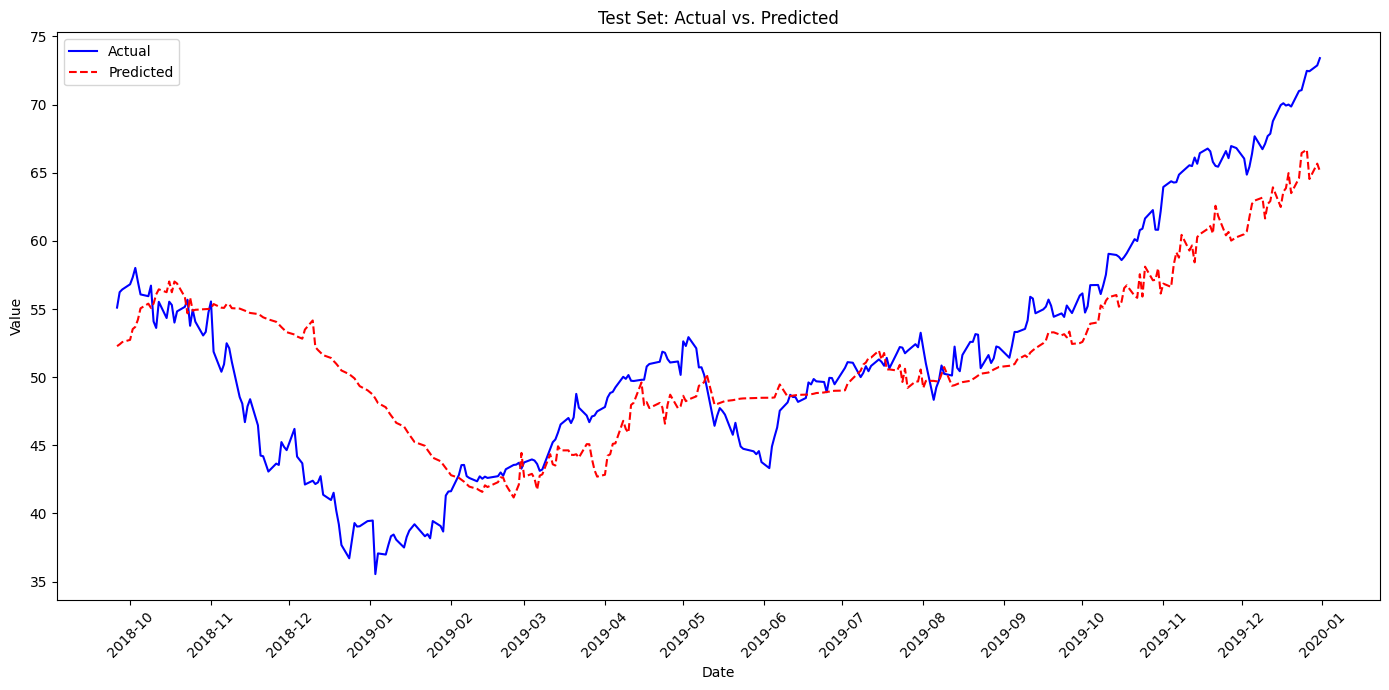

In [44]:
# Plot actual vs. predicted values
tick_interval = 'M'
plot_test_predictions(
    test_preds_inv,
    test_trues_inv,
    test_df_dates,
    tick_interval=tick_interval
)

# Hyperparameter Tuning

In [45]:
def objective(trial: Trial) -> Tuple[float, float]:
    """
    Objective function for Optuna hyperparameter tuning of SpikformerModel.

    Args:
        trial (Trial): Optuna trial object.

    Returns:
        Tuple[float, float]: Minimum validation loss and loss gap.
    """
    try:
        # ----- Hyperparameter Selection -----

        # Number of attention heads (2, 4, 6, or 8)
        heads = trial.suggest_int("heads", 2, 8, step=2)

        # Dim factor multiplier
        max_dim_factor_multiplier = (512 // heads) // 32
        max_dim_factor_multiplier = max(max_dim_factor_multiplier, 1)  # Ensure at least 1

        dim_factor_multiplier = trial.suggest_int(
            "dim_factor_multiplier",
            1,
            min(16, max_dim_factor_multiplier)
        )
        dim_factor = 32 * dim_factor_multiplier
        dim = heads * dim_factor  # Ensure dim <= 512

        # Determine d_ff_factor based on dim to ensure d_ff <= 1024
        if dim <= 256:
            if 4 * dim <= 1024:
                d_ff_factor = trial.suggest_int("d_ff_factor", 2, 4, step=2)
            else:
                d_ff_factor = 2
        else:
            d_ff_factor = 2  # Fixed to ensure d_ff <= 1024
        d_ff = dim * d_ff_factor

        # Assertions to ensure constraints
        assert dim <= 512, f"dim {dim} exceeds 512"
        assert d_ff <= 1024, f"d_ff {d_ff} exceeds 1024"

        # Additional hyperparameters
        num_pe_neuron = trial.suggest_int("num_pe_neuron", 1, 50)
        depths = trial.suggest_int("depths", 1, 2)
        num_steps = trial.suggest_int("num_steps", 2, 8, step=2)
        qkv_bias = trial.suggest_categorical("qkv_bias", [False, True])
        qk_scale = trial.suggest_float("qk_scale", 0.125, 1.0, step=0.125)
        pe_type = trial.suggest_categorical("pe_type", ["neuron", "conv"])
        pe_mode = trial.suggest_categorical("pe_mode", ["add", "concat"])
        neuron_pe_scale = trial.suggest_categorical("neuron_pe_scale", [100.0, 1000.0, 10000.0])
        lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
        weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
        features_to_normalize = trial.suggest_categorical("features_to_normalize", [[0], "all"])

        # Scheduler and early stopping parameters
        early_stopping_patience = trial.suggest_int("early_stopping_patience", 4, 20)
        max_lr_scheduler_patience = max(early_stopping_patience - 1, 1)
        lr_scheduler_patience = trial.suggest_int("lr_scheduler_patience", 2, max_lr_scheduler_patience)
        lr_scheduler_factor = trial.suggest_float("lr_scheduler_factor", 0.1, 0.7)

        print(f"Starting trial {trial.number} with parameters {trial.params}")

        # ----- Model Initialization -----

        model = SpikformerModel(
            dim=dim,
            d_ff=d_ff,
            num_pe_neuron=num_pe_neuron,
            pe_type=pe_type,
            pe_mode=pe_mode,
            neuron_pe_scale=neuron_pe_scale,
            depths=depths,
            common_thr=1.0,
            max_length=5000,
            num_steps=num_steps,
            heads=heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            input_size=6,
            aggregate=True,
            normalize=True,
            features_to_normalize=features_to_normalize,
            target_index=0
        ).to(device)

        # ----- Loss Function and Optimizer -----

        criterion = nn.MSELoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        checkpoint_path = f"best_model_trial_{trial.number}.pth"

        # ----- Training Loop -----

        trained_model, history, best_epoch = run_training(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            epochs=1000,
            early_stopping_patience=early_stopping_patience,
            lr_scheduler_patience=lr_scheduler_patience,
            lr_scheduler_factor=lr_scheduler_factor,
            print_progress=False,
            report_freq=1,
            checkpoint_path=checkpoint_path
        )

        # ----- Validation Metrics -----

        val_losses = history['val_loss']
        min_val_loss = min(val_losses)
        max_val_loss = max(val_losses)
        loss_gap = max_val_loss - min_val_loss

        # Store additional info
        trial.set_user_attr("best_epoch", best_epoch)

        return min_val_loss, loss_gap

    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"Trial {trial.number} failed due to OOM.")
            torch.cuda.empty_cache()
            trial.set_user_attr("best_epoch", 0)
            return float("inf"), float("inf")
        else:
            raise
    except AssertionError as ae:
        print(f"Trial {trial.number} failed constraint: {ae}")
        trial.set_user_attr("best_epoch", 0)
        return float("inf"), float("inf")
    except Exception as e:
        print(f"Trial {trial.number} failed: {e}")
        trial.set_user_attr("best_epoch", 0)
        return float("inf"), float("inf")

In [46]:
# Initialize the study
study = optuna.create_study(
    study_name="spikformer_optimization",
    directions=["minimize", "minimize"],
)

# Run the study
study.optimize(objective, n_trials=10, timeout=7200)

[I 2024-12-30 20:37:26,520] A new study created in memory with name: spikformer_optimization


Starting trial 0 with parameters {'heads': 6, 'dim_factor_multiplier': 1, 'd_ff_factor': 2, 'num_pe_neuron': 49, 'depths': 1, 'num_steps': 8, 'qkv_bias': False, 'qk_scale': 0.875, 'pe_type': 'conv', 'pe_mode': 'add', 'neuron_pe_scale': 100.0, 'lr': 0.00033335916649290126, 'weight_decay': 0.006445931405521512, 'features_to_normalize': 'all', 'early_stopping_patience': 6, 'lr_scheduler_patience': 5, 'lr_scheduler_factor': 0.21630620401300077}


[I 2024-12-30 20:38:06,877] Trial 0 finished with values: [0.07316291600183733, 0.008498806870698178] and parameters: {'heads': 6, 'dim_factor_multiplier': 1, 'd_ff_factor': 2, 'num_pe_neuron': 49, 'depths': 1, 'num_steps': 8, 'qkv_bias': False, 'qk_scale': 0.875, 'pe_type': 'conv', 'pe_mode': 'add', 'neuron_pe_scale': 100.0, 'lr': 0.00033335916649290126, 'weight_decay': 0.006445931405521512, 'features_to_normalize': 'all', 'early_stopping_patience': 6, 'lr_scheduler_patience': 5, 'lr_scheduler_factor': 0.21630620401300077}.


Starting trial 1 with parameters {'heads': 4, 'dim_factor_multiplier': 1, 'd_ff_factor': 4, 'num_pe_neuron': 9, 'depths': 1, 'num_steps': 6, 'qkv_bias': False, 'qk_scale': 0.375, 'pe_type': 'conv', 'pe_mode': 'concat', 'neuron_pe_scale': 100.0, 'lr': 3.1638645307439806e-05, 'weight_decay': 0.00023985403274610594, 'features_to_normalize': 'all', 'early_stopping_patience': 16, 'lr_scheduler_patience': 5, 'lr_scheduler_factor': 0.3096346664909516}


[I 2024-12-30 20:42:24,953] Trial 1 finished with values: [0.07826256488775982, 0.00715978984200992] and parameters: {'heads': 4, 'dim_factor_multiplier': 1, 'd_ff_factor': 4, 'num_pe_neuron': 9, 'depths': 1, 'num_steps': 6, 'qkv_bias': False, 'qk_scale': 0.375, 'pe_type': 'conv', 'pe_mode': 'concat', 'neuron_pe_scale': 100.0, 'lr': 3.1638645307439806e-05, 'weight_decay': 0.00023985403274610594, 'features_to_normalize': 'all', 'early_stopping_patience': 16, 'lr_scheduler_patience': 5, 'lr_scheduler_factor': 0.3096346664909516}.


Starting trial 2 with parameters {'heads': 4, 'dim_factor_multiplier': 2, 'd_ff_factor': 2, 'num_pe_neuron': 33, 'depths': 1, 'num_steps': 2, 'qkv_bias': False, 'qk_scale': 1.0, 'pe_type': 'conv', 'pe_mode': 'add', 'neuron_pe_scale': 100.0, 'lr': 0.003371316872242809, 'weight_decay': 0.00011149346931540658, 'features_to_normalize': [0], 'early_stopping_patience': 14, 'lr_scheduler_patience': 11, 'lr_scheduler_factor': 0.4373523295327718}


[I 2024-12-30 20:42:43,989] Trial 2 finished with values: [0.04831476182873693, 0.0298337219547398] and parameters: {'heads': 4, 'dim_factor_multiplier': 2, 'd_ff_factor': 2, 'num_pe_neuron': 33, 'depths': 1, 'num_steps': 2, 'qkv_bias': False, 'qk_scale': 1.0, 'pe_type': 'conv', 'pe_mode': 'add', 'neuron_pe_scale': 100.0, 'lr': 0.003371316872242809, 'weight_decay': 0.00011149346931540658, 'features_to_normalize': [0], 'early_stopping_patience': 14, 'lr_scheduler_patience': 11, 'lr_scheduler_factor': 0.4373523295327718}.


Starting trial 3 with parameters {'heads': 2, 'dim_factor_multiplier': 5, 'num_pe_neuron': 48, 'depths': 1, 'num_steps': 2, 'qkv_bias': True, 'qk_scale': 0.125, 'pe_type': 'conv', 'pe_mode': 'concat', 'neuron_pe_scale': 1000.0, 'lr': 0.0019273297074994995, 'weight_decay': 0.006134946899151974, 'features_to_normalize': 'all', 'early_stopping_patience': 19, 'lr_scheduler_patience': 17, 'lr_scheduler_factor': 0.31470682966443464}


[I 2024-12-30 20:43:11,205] Trial 3 finished with values: [0.059977999479988775, 0.0933236761330054] and parameters: {'heads': 2, 'dim_factor_multiplier': 5, 'num_pe_neuron': 48, 'depths': 1, 'num_steps': 2, 'qkv_bias': True, 'qk_scale': 0.125, 'pe_type': 'conv', 'pe_mode': 'concat', 'neuron_pe_scale': 1000.0, 'lr': 0.0019273297074994995, 'weight_decay': 0.006134946899151974, 'features_to_normalize': 'all', 'early_stopping_patience': 19, 'lr_scheduler_patience': 17, 'lr_scheduler_factor': 0.31470682966443464}.


Starting trial 4 with parameters {'heads': 4, 'dim_factor_multiplier': 2, 'd_ff_factor': 2, 'num_pe_neuron': 5, 'depths': 1, 'num_steps': 4, 'qkv_bias': False, 'qk_scale': 0.25, 'pe_type': 'neuron', 'pe_mode': 'add', 'neuron_pe_scale': 1000.0, 'lr': 0.00013519007565138312, 'weight_decay': 1.4670670456815732e-05, 'features_to_normalize': [0], 'early_stopping_patience': 19, 'lr_scheduler_patience': 12, 'lr_scheduler_factor': 0.44475012757544996}
pe.shape:  torch.Size([50000, 1, 6])


[I 2024-12-30 20:49:00,641] Trial 4 finished with values: [0.0625200558112999, 0.016533126872420686] and parameters: {'heads': 4, 'dim_factor_multiplier': 2, 'd_ff_factor': 2, 'num_pe_neuron': 5, 'depths': 1, 'num_steps': 4, 'qkv_bias': False, 'qk_scale': 0.25, 'pe_type': 'neuron', 'pe_mode': 'add', 'neuron_pe_scale': 1000.0, 'lr': 0.00013519007565138312, 'weight_decay': 1.4670670456815732e-05, 'features_to_normalize': [0], 'early_stopping_patience': 19, 'lr_scheduler_patience': 12, 'lr_scheduler_factor': 0.44475012757544996}.


Starting trial 5 with parameters {'heads': 6, 'dim_factor_multiplier': 2, 'num_pe_neuron': 50, 'depths': 2, 'num_steps': 2, 'qkv_bias': False, 'qk_scale': 0.25, 'pe_type': 'conv', 'pe_mode': 'concat', 'neuron_pe_scale': 10000.0, 'lr': 0.005358621576296179, 'weight_decay': 0.0003109873299588868, 'features_to_normalize': [0], 'early_stopping_patience': 9, 'lr_scheduler_patience': 6, 'lr_scheduler_factor': 0.40224050128246946}


[I 2024-12-30 20:50:00,207] Trial 5 finished with values: [0.04820753807901208, 0.025010778395347405] and parameters: {'heads': 6, 'dim_factor_multiplier': 2, 'num_pe_neuron': 50, 'depths': 2, 'num_steps': 2, 'qkv_bias': False, 'qk_scale': 0.25, 'pe_type': 'conv', 'pe_mode': 'concat', 'neuron_pe_scale': 10000.0, 'lr': 0.005358621576296179, 'weight_decay': 0.0003109873299588868, 'features_to_normalize': [0], 'early_stopping_patience': 9, 'lr_scheduler_patience': 6, 'lr_scheduler_factor': 0.40224050128246946}.


Starting trial 6 with parameters {'heads': 2, 'dim_factor_multiplier': 6, 'num_pe_neuron': 41, 'depths': 1, 'num_steps': 2, 'qkv_bias': False, 'qk_scale': 0.875, 'pe_type': 'conv', 'pe_mode': 'add', 'neuron_pe_scale': 100.0, 'lr': 4.1598129310646084e-05, 'weight_decay': 0.009717048905870333, 'features_to_normalize': [0], 'early_stopping_patience': 17, 'lr_scheduler_patience': 15, 'lr_scheduler_factor': 0.1807420930010316}


[I 2024-12-30 21:09:35,012] Trial 6 finished with values: [0.05393224757176469, 0.02578031433869612] and parameters: {'heads': 2, 'dim_factor_multiplier': 6, 'num_pe_neuron': 41, 'depths': 1, 'num_steps': 2, 'qkv_bias': False, 'qk_scale': 0.875, 'pe_type': 'conv', 'pe_mode': 'add', 'neuron_pe_scale': 100.0, 'lr': 4.1598129310646084e-05, 'weight_decay': 0.009717048905870333, 'features_to_normalize': [0], 'early_stopping_patience': 17, 'lr_scheduler_patience': 15, 'lr_scheduler_factor': 0.1807420930010316}.


Starting trial 7 with parameters {'heads': 6, 'dim_factor_multiplier': 1, 'd_ff_factor': 2, 'num_pe_neuron': 13, 'depths': 1, 'num_steps': 2, 'qkv_bias': True, 'qk_scale': 1.0, 'pe_type': 'conv', 'pe_mode': 'concat', 'neuron_pe_scale': 10000.0, 'lr': 7.325721948596055e-05, 'weight_decay': 2.1594167664117226e-05, 'features_to_normalize': [0], 'early_stopping_patience': 15, 'lr_scheduler_patience': 12, 'lr_scheduler_factor': 0.2362155034639925}


[I 2024-12-30 21:14:29,474] Trial 7 finished with values: [0.05315136343052711, 0.026573465731617785] and parameters: {'heads': 6, 'dim_factor_multiplier': 1, 'd_ff_factor': 2, 'num_pe_neuron': 13, 'depths': 1, 'num_steps': 2, 'qkv_bias': True, 'qk_scale': 1.0, 'pe_type': 'conv', 'pe_mode': 'concat', 'neuron_pe_scale': 10000.0, 'lr': 7.325721948596055e-05, 'weight_decay': 2.1594167664117226e-05, 'features_to_normalize': [0], 'early_stopping_patience': 15, 'lr_scheduler_patience': 12, 'lr_scheduler_factor': 0.2362155034639925}.


Starting trial 8 with parameters {'heads': 8, 'dim_factor_multiplier': 1, 'd_ff_factor': 2, 'num_pe_neuron': 33, 'depths': 1, 'num_steps': 6, 'qkv_bias': False, 'qk_scale': 0.5, 'pe_type': 'conv', 'pe_mode': 'concat', 'neuron_pe_scale': 100.0, 'lr': 0.009542086355060653, 'weight_decay': 0.005856490213202819, 'features_to_normalize': [0], 'early_stopping_patience': 19, 'lr_scheduler_patience': 8, 'lr_scheduler_factor': 0.1311171776414192}


[I 2024-12-30 21:16:15,184] Trial 8 finished with values: [0.04824244078213484, 0.04254356080707315] and parameters: {'heads': 8, 'dim_factor_multiplier': 1, 'd_ff_factor': 2, 'num_pe_neuron': 33, 'depths': 1, 'num_steps': 6, 'qkv_bias': False, 'qk_scale': 0.5, 'pe_type': 'conv', 'pe_mode': 'concat', 'neuron_pe_scale': 100.0, 'lr': 0.009542086355060653, 'weight_decay': 0.005856490213202819, 'features_to_normalize': [0], 'early_stopping_patience': 19, 'lr_scheduler_patience': 8, 'lr_scheduler_factor': 0.1311171776414192}.


Starting trial 9 with parameters {'heads': 2, 'dim_factor_multiplier': 6, 'num_pe_neuron': 5, 'depths': 2, 'num_steps': 8, 'qkv_bias': True, 'qk_scale': 1.0, 'pe_type': 'conv', 'pe_mode': 'add', 'neuron_pe_scale': 100.0, 'lr': 0.002141241500922316, 'weight_decay': 0.0012182641749149928, 'features_to_normalize': [0], 'early_stopping_patience': 20, 'lr_scheduler_patience': 16, 'lr_scheduler_factor': 0.5370673332994197}


[I 2024-12-30 21:24:51,550] Trial 9 finished with values: [0.0488803388333471, 0.05535495854702658] and parameters: {'heads': 2, 'dim_factor_multiplier': 6, 'num_pe_neuron': 5, 'depths': 2, 'num_steps': 8, 'qkv_bias': True, 'qk_scale': 1.0, 'pe_type': 'conv', 'pe_mode': 'add', 'neuron_pe_scale': 100.0, 'lr': 0.002141241500922316, 'weight_decay': 0.0012182641749149928, 'features_to_normalize': [0], 'early_stopping_patience': 20, 'lr_scheduler_patience': 16, 'lr_scheduler_factor': 0.5370673332994197}.


In [47]:
def display_plotly_with_static(fig: Figure, static_format: str = 'png') -> None:
    """
    Displays both an interactive Plotly figure and a static image version.

    Args:
        fig (plotly.graph_objects.Figure): A Plotly figure object.
        static_format (str, optional): The format for the static image ('png', 'svg', etc.).
                                       Defaults to 'png'.
    """
    # Display interactive plot
    fig.show()
    print("\n")

    # Generate and display static image
    try:
        img_bytes = pio.to_image(fig, format=static_format)

        # Display the static image
        if static_format.lower() == 'svg':
            display(SVG(img_bytes))
        else:
            display(Image(img_bytes))
    except ValueError as ve:
        print(f"\nInvalid format '{static_format}'. Please choose a supported format (e.g., 'png', 'svg').")
        print(f"Error details: {ve}")
    except Exception as e:
        print(f"\nAn error occurred while generating the static image: {e}")

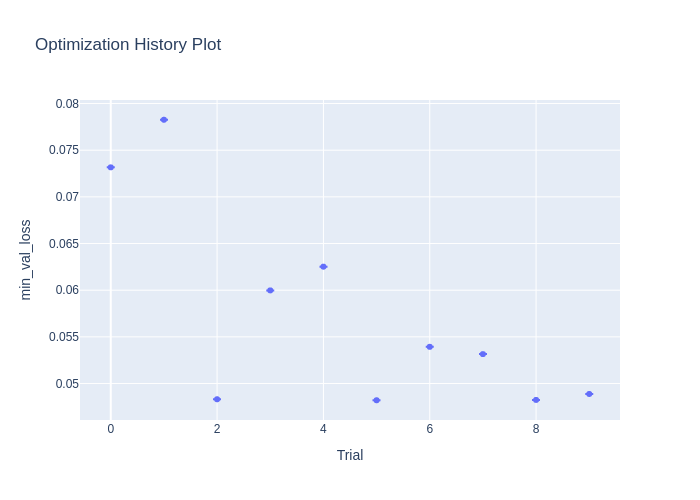

In [48]:
# Plot optimization history for min_val_loss
opt_history_val_loss = plot_optimization_history(
    study,
    target=lambda t: t.values[0],
    target_name="min_val_loss",
    error_bar=True
)
display_plotly_with_static(opt_history_val_loss)

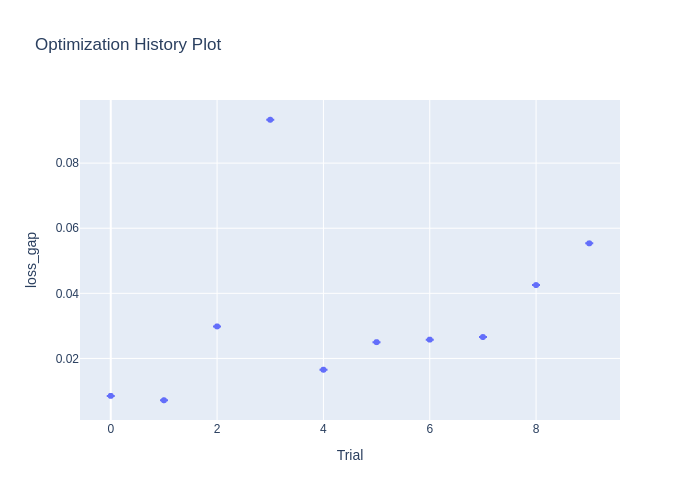

In [49]:
# Plot optimization history for loss_gap
opt_history_loss_gap = plot_optimization_history(
    study,
    target=lambda t: t.values[1],
    target_name="loss_gap",
    error_bar=True
)
display_plotly_with_static(opt_history_loss_gap)

Number of trials on the Pareto front: 4



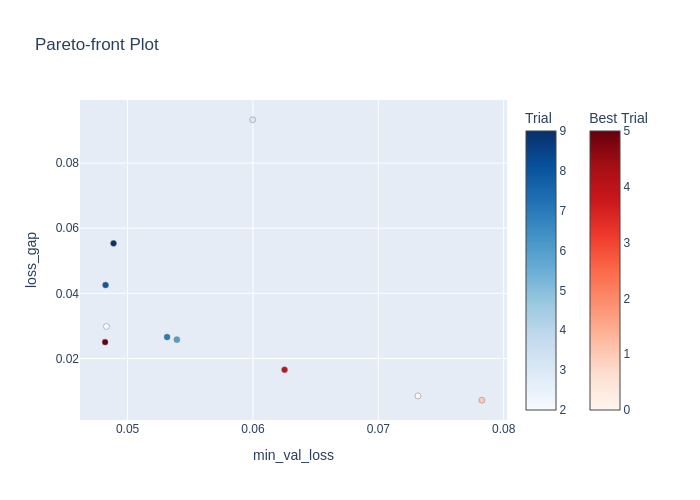

In [50]:
# Print the number of trials on the Pareto front
print(f"Number of trials on the Pareto front: {len(study.best_trials)}\n")

# Visualize the Pareto front
pareto_fig = plot_pareto_front(
    study,
    target_names=["min_val_loss", "loss_gap"]
)
display_plotly_with_static(pareto_fig)

In [51]:
# Get reference point
pareto_trials = study.best_trials
min_val_loss_values = [trial.values[0] for trial in pareto_trials]
loss_gap_values = [trial.values[1] for trial in pareto_trials]
ref_min_val_loss = max(min_val_loss_values) * 1.1
ref_loss_gap = max(loss_gap_values) * 1.1
reference_point = [ref_min_val_loss, ref_loss_gap]

print(f"Reference Point: min_val_loss={ref_min_val_loss:.4f}, loss_gap={ref_loss_gap:.4f}")

Reference Point: min_val_loss=0.0861, loss_gap=0.0275


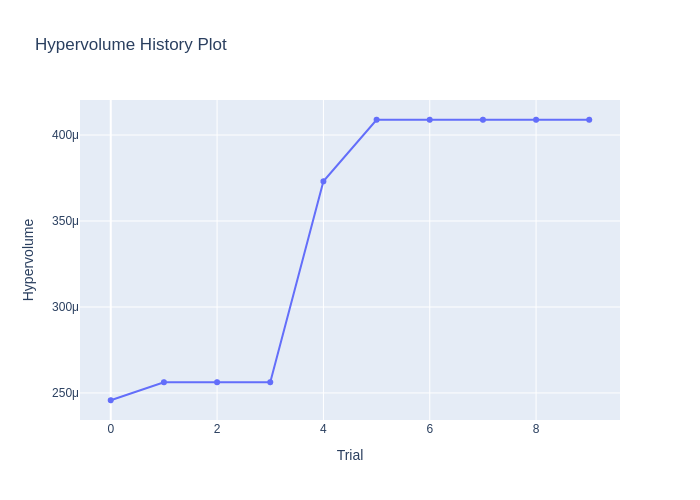

In [52]:
# Plot the hypervolume history
hypervolume_fig = plot_hypervolume_history(
    study,
    reference_point=reference_point
)
display_plotly_with_static(hypervolume_fig)

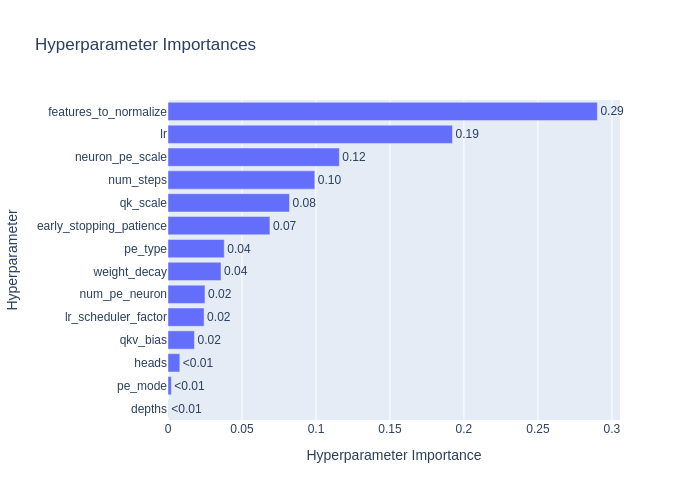

In [53]:
# Plot parameter importances for min_val_loss
param_imp_val_loss = plot_param_importances(
    study,
    target=lambda t: t.values[0],
    target_name="min_val_loss"
)
display_plotly_with_static(param_imp_val_loss)

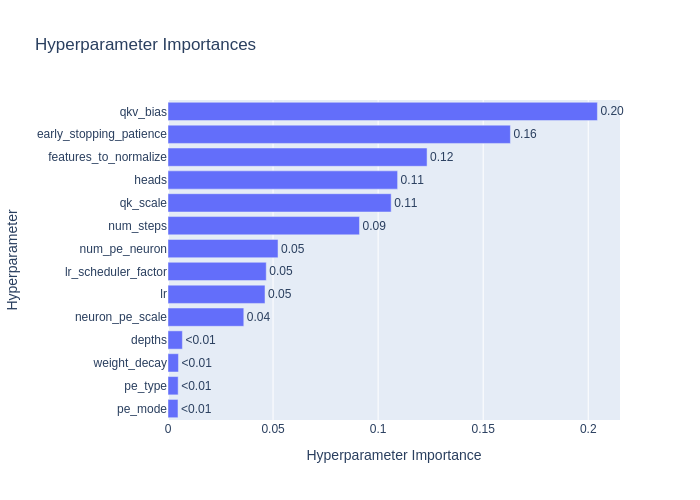

In [54]:
# Plot parameter importances for loss_gap
param_imp_loss_gap = plot_param_importances(
    study,
    target=lambda t: t.values[1],
    target_name="loss_gap"
)
display_plotly_with_static(param_imp_loss_gap)

In [55]:
# Select the trial with the lowest validation loss
trial_with_lowest_val_loss = min(study.best_trials, key=lambda t: t.values[0])

print("Trial with lowest min_val_loss:")
print(f"\tnumber: {trial_with_lowest_val_loss.number}")
print(f"\tparams: {trial_with_lowest_val_loss.params}")
print(f"\tvalues: {trial_with_lowest_val_loss.values}")

Trial with lowest min_val_loss:
	number: 5
	params: {'heads': 6, 'dim_factor_multiplier': 2, 'num_pe_neuron': 50, 'depths': 2, 'num_steps': 2, 'qkv_bias': False, 'qk_scale': 0.25, 'pe_type': 'conv', 'pe_mode': 'concat', 'neuron_pe_scale': 10000.0, 'lr': 0.005358621576296179, 'weight_decay': 0.0003109873299588868, 'features_to_normalize': [0], 'early_stopping_patience': 9, 'lr_scheduler_patience': 6, 'lr_scheduler_factor': 0.40224050128246946}
	values: [0.04820753807901208, 0.025010778395347405]


In [56]:
# Select the trial with the lowest loss gap
trial_with_lowest_loss_gap = min(study.best_trials, key=lambda t: t.values[1])

print("Trial with lowest loss_gap:")
print(f"\tnumber: {trial_with_lowest_loss_gap.number}")
print(f"\tparams: {trial_with_lowest_loss_gap.params}")
print(f"\tvalues: {trial_with_lowest_loss_gap.values}")

Trial with lowest loss_gap:
	number: 1
	params: {'heads': 4, 'dim_factor_multiplier': 1, 'd_ff_factor': 4, 'num_pe_neuron': 9, 'depths': 1, 'num_steps': 6, 'qkv_bias': False, 'qk_scale': 0.375, 'pe_type': 'conv', 'pe_mode': 'concat', 'neuron_pe_scale': 100.0, 'lr': 3.1638645307439806e-05, 'weight_decay': 0.00023985403274610594, 'features_to_normalize': 'all', 'early_stopping_patience': 16, 'lr_scheduler_patience': 5, 'lr_scheduler_factor': 0.3096346664909516}
	values: [0.07826256488775982, 0.00715978984200992]


In [57]:
# Show all trials and values
for trial in study.trials:
    print(f"Trial {trial.number}:")
    print(f"\tValue: {trial.values}")
    print(f"\tParams: {trial.params}")
    print()

Trial 0:
	Value: [0.07316291600183733, 0.008498806870698178]
	Params: {'heads': 6, 'dim_factor_multiplier': 1, 'd_ff_factor': 2, 'num_pe_neuron': 49, 'depths': 1, 'num_steps': 8, 'qkv_bias': False, 'qk_scale': 0.875, 'pe_type': 'conv', 'pe_mode': 'add', 'neuron_pe_scale': 100.0, 'lr': 0.00033335916649290126, 'weight_decay': 0.006445931405521512, 'features_to_normalize': 'all', 'early_stopping_patience': 6, 'lr_scheduler_patience': 5, 'lr_scheduler_factor': 0.21630620401300077}

Trial 1:
	Value: [0.07826256488775982, 0.00715978984200992]
	Params: {'heads': 4, 'dim_factor_multiplier': 1, 'd_ff_factor': 4, 'num_pe_neuron': 9, 'depths': 1, 'num_steps': 6, 'qkv_bias': False, 'qk_scale': 0.375, 'pe_type': 'conv', 'pe_mode': 'concat', 'neuron_pe_scale': 100.0, 'lr': 3.1638645307439806e-05, 'weight_decay': 0.00023985403274610594, 'features_to_normalize': 'all', 'early_stopping_patience': 16, 'lr_scheduler_patience': 5, 'lr_scheduler_factor': 0.3096346664909516}

Trial 2:
	Value: [0.04831476182

In [58]:
def select_best_trial(
    study: optuna.Study,
    min_epochs: int = 10,
    method: str = "percentile",
    tolerance_param: float = 90.0,
    std_multiplier: float = 1.0,
    relative_proximity: float = 0.01
) -> optuna.Trial:
    """
    Selects the best trial from an Optuna study based on dynamic tolerance methods.

    Args:
        study (optuna.Study): The Optuna study containing trials.
        min_epochs (int, optional): Minimum number of epochs a trial must have run. Defaults to 10.
        method (str, optional): Dynamic tolerance method to use. Options: "percentile", "std_dev", "relative_proximity". Defaults to "percentile".
        tolerance_param (float, optional):
            - If method is "percentile", this is the percentile (0-100).
            - If method is "std_dev", this is the number of standard deviations.
            - If method is "relative_proximity", this is the relative proximity threshold (e.g., 0.05 for 5%).
            Defaults to 90.0.
        std_multiplier (float, optional): Number of standard deviations for "std_dev" method. Defaults to 1.0.
        relative_proximity (float, optional): Relative proximity threshold for "relative_proximity" method. Defaults to 0.01.

    Returns:
        optuna.Trial: The selected best trial based on the criteria.
    """

    # Validate method input
    valid_methods = ["percentile", "std_dev", "relative_proximity"]
    if method not in valid_methods:
        raise ValueError(f"Invalid method '{method}'. Choose from {valid_methods}.")

    # Step 1: Filter trials based on the minimum epochs threshold
    eligible_trials = [
        trial for trial in study.trials
        if trial.state == optuna.trial.TrialState.COMPLETE
        and trial.user_attrs.get("best_epoch", 0) >= min_epochs
    ]

    # Check if there are any eligible trials
    if not eligible_trials:
        raise ValueError(f"No trials met the epoch threshold of {min_epochs}.")

    # Extract val_loss and loss_gap from eligible trials
    val_losses = [trial.values[0] for trial in eligible_trials]
    loss_gaps = [trial.values[1] for trial in eligible_trials]

    # Step 2: Determine dynamic TOLERANCE based on the selected method
    if method == "percentile":
        if not (0 < tolerance_param < 100):
            raise ValueError("For 'percentile' method, tolerance_param must be between 0 and 100.")
        min_val_loss = min(val_losses)
        percentile_val_loss = np.percentile(val_losses, tolerance_param)
        max_acceptable_val_loss = percentile_val_loss
        print(f"Selected Method: Percentile")
        print(f"Val_loss at the {tolerance_param}th percentile: {percentile_val_loss:.6f}")

    elif method == "std_dev":
        if tolerance_param <= 0:
            raise ValueError("For 'std_dev' method, tolerance_param must be positive.")
        min_val_loss = min(val_losses)
        mean_val_loss = np.mean(val_losses)
        std_val_loss = np.std(val_losses)
        max_acceptable_val_loss = mean_val_loss + std_multiplier * std_val_loss
        print(f"Selected Method: Standard Deviation")
        print(f"Mean Val_loss: {mean_val_loss:.6f}")
        print(f"Standard Deviation of Val_loss: {std_val_loss:.6f}")
        print(f"Max Acceptable Val_loss (Mean + {std_multiplier} * STD): {max_acceptable_val_loss:.6f}")

    elif method == "relative_proximity":
        if not (0 < relative_proximity < 1):
            raise ValueError("For 'relative_proximity' method, relative_proximity must be between 0 and 1.")
        min_val_loss = min(val_losses)
        max_acceptable_val_loss = min_val_loss * (1 + relative_proximity)
        print(f"Selected Method: Relative Proximity")
        print(f"Minimum Val_loss: {min_val_loss:.6f}")
        print(f"Max Acceptable Val_loss (Min Val_loss * (1 + {relative_proximity*100}%)): {max_acceptable_val_loss:.6f}")

    # Step 3: Filter trials within the dynamic TOLERANCE
    close_trials = [
        trial for trial in eligible_trials
        if trial.values[0] <= max_acceptable_val_loss
    ]

    # Check if there are any trials within the tolerance
    if not close_trials:
        if method == "percentile":
            msg = f"No trials found within the {tolerance_param}th percentile of val_loss ({max_acceptable_val_loss:.6f})."
        elif method == "std_dev":
            msg = f"No trials found within {std_multiplier} standard deviations of the mean val_loss ({max_acceptable_val_loss:.6f})."
        elif method == "relative_proximity":
            msg = f"No trials found within the relative proximity threshold of {relative_proximity*100}%. "
        raise ValueError(msg + " Consider adjusting the tolerance parameters or reviewing the epoch threshold.")

    # Step 4: Select the trial with the lowest loss_gap among the close trials
    best_trial = min(close_trials, key=lambda t: t.values[1])

    # Display the best trial details
    print("\nBest Generalized Trial:")
    print(f"\tNumber: {best_trial.number}")
    print(f"\tParams: {best_trial.params}")
    print(f"\tValues: Min Loss={best_trial.values[0]:.6f}, Loss Gap={best_trial.values[1]:.6f}")
    print(f"\tEpochs: {best_trial.user_attrs.get('best_epoch', 'N/A')}")

    return best_trial

In [59]:
# Define selection parameters
selection_method = "relative_proximity"  # "percentile", "std_dev", "relative_proximity"
tolerance_param = 90.0                   # For "percentile": percentile value (0-100)
# tolerance_param = 1.0                  # For "std_dev": number of standard deviations

std_multiplier = 1.0
relative_proximity = 0.20

# Select the best trial
try:
    best_trial = select_best_trial(
        study=study,
        min_epochs=10,
        method=selection_method,
        tolerance_param=tolerance_param,
        std_multiplier=std_multiplier,
        relative_proximity=relative_proximity
    )
except ValueError as e:
    print(f"Selection Error: {e}")

Selected Method: Relative Proximity
Minimum Val_loss: 0.048208
Max Acceptable Val_loss (Min Val_loss * (1 + 20.0%)): 0.057849

Best Generalized Trial:
	Number: 5
	Params: {'heads': 6, 'dim_factor_multiplier': 2, 'num_pe_neuron': 50, 'depths': 2, 'num_steps': 2, 'qkv_bias': False, 'qk_scale': 0.25, 'pe_type': 'conv', 'pe_mode': 'concat', 'neuron_pe_scale': 10000.0, 'lr': 0.005358621576296179, 'weight_decay': 0.0003109873299588868, 'features_to_normalize': [0], 'early_stopping_patience': 9, 'lr_scheduler_patience': 6, 'lr_scheduler_factor': 0.40224050128246946}
	Values: Min Loss=0.048208, Loss Gap=0.025011
	Epochs: 18


In [60]:
# Retrieve the best hyperparameters from the best trial
best_params = best_trial.params.copy()

In [61]:
# Extract constrained hyperparameters
best_heads = best_params["heads"]

# Calculate maximum allowed multiplier to ensure dim <= 512
max_dim_factor = 512 // best_heads
max_multiplier = max_dim_factor // 32
max_multiplier = max(max_multiplier, 1)  # Ensure at least 1

# Extract and cap the multiplier
best_dim_factor_multiplier = min(best_params["dim_factor_multiplier"], max_multiplier)
best_dim_factor = 32 * best_dim_factor_multiplier
best_dim = best_heads * best_dim_factor

if best_dim <= 256:
    best_d_ff_factor = best_params["d_ff_factor"]
else:
    best_d_ff_factor = 2
best_d_ff = best_dim * best_d_ff_factor

assert best_dim <= 512, f"best_dim {best_dim} exceeds 512"
assert best_d_ff <= 1024, f"best_d_ff {best_d_ff} exceeds 1024"

print(f"best_dim_factor_multiplier: {best_dim_factor_multiplier}")
print(f"best_dim_factor: {best_dim_factor}")
print(f"best_dim: {best_dim}")

print(f"\nbest_d_ff_factor: {best_d_ff_factor}")
print(f"best_d_ff: {best_d_ff}")

best_dim_factor_multiplier: 2
best_dim_factor: 64
best_dim: 384

best_d_ff_factor: 2
best_d_ff: 768


In [62]:
# Extract other hyperparameters
best_num_pe_neuron = best_params["num_pe_neuron"]
best_pe_type = best_params["pe_type"]
best_pe_mode = best_params["pe_mode"]
best_neuron_pe_scale = best_params["neuron_pe_scale"]
best_depths = best_params["depths"]
best_num_steps = best_params["num_steps"]
best_qkv_bias = best_params["qkv_bias"]
best_qk_scale = best_params["qk_scale"]
best_lr = best_params["lr"]
best_weight_decay = best_params["weight_decay"]
best_features_to_normalize = best_params["features_to_normalize"]
best_early_stopping_patience = best_params["early_stopping_patience"]
best_lr_scheduler_patience = best_params["lr_scheduler_patience"]
best_lr_scheduler_factor = best_params["lr_scheduler_factor"]

# Re-Training

In [63]:
# Initialize the final model
final_model = SpikformerModel(
    dim=best_dim,
    d_ff=best_d_ff,
    num_pe_neuron=best_num_pe_neuron,
    pe_type=best_pe_type,
    pe_mode=best_pe_mode,
    neuron_pe_scale=best_neuron_pe_scale,
    depths=best_depths,
    common_thr=1.0,
    max_length=5000,
    num_steps=best_num_steps,
    heads=best_heads,
    qkv_bias=best_qkv_bias,
    qk_scale=best_qk_scale,
    input_size=6,
    aggregate=True,
    normalize=True,
    features_to_normalize=best_features_to_normalize,
    target_index=0
).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(final_model.parameters(), lr=best_lr, weight_decay=best_weight_decay)

In [64]:
set_seed(42)

# Train the final model
final_trained_model, final_history, final_best_epoch = run_training(
    final_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=epochs,
    early_stopping_patience=best_early_stopping_patience,
    lr_scheduler_patience=best_lr_scheduler_patience,
    lr_scheduler_factor=best_lr_scheduler_factor,
    print_progress=print_progress,
    report_freq=report_freq,
    checkpoint_path=checkpoint_path
)

Epoch 1/1000 - Train Loss: 0.0481 | Val Loss: 0.0760 | Time: 2.23s | LR: 5.36e-03
Epoch 2/1000 - Train Loss: 0.0472 | Val Loss: 0.0722 | Time: 2.17s | LR: 5.36e-03
Epoch 3/1000 - Train Loss: 0.0510 | Val Loss: 0.1209 | Time: 2.20s | LR: 5.36e-03
Epoch 4/1000 - Train Loss: 0.0455 | Val Loss: 0.0684 | Time: 2.20s | LR: 5.36e-03
Epoch 5/1000 - Train Loss: 0.0449 | Val Loss: 0.0555 | Time: 2.19s | LR: 5.36e-03
Epoch 6/1000 - Train Loss: 0.0449 | Val Loss: 0.0782 | Time: 2.20s | LR: 5.36e-03
Epoch 7/1000 - Train Loss: 0.0436 | Val Loss: 0.0808 | Time: 2.20s | LR: 5.36e-03
Epoch 8/1000 - Train Loss: 0.0432 | Val Loss: 0.0748 | Time: 2.21s | LR: 5.36e-03
Epoch 9/1000 - Train Loss: 0.0436 | Val Loss: 0.0511 | Time: 2.20s | LR: 5.36e-03
Epoch 10/1000 - Train Loss: 0.0436 | Val Loss: 0.0551 | Time: 2.20s | LR: 5.36e-03
Epoch 11/1000 - Train Loss: 0.0435 | Val Loss: 0.0614 | Time: 2.20s | LR: 5.36e-03
Epoch 12/1000 - Train Loss: 0.0425 | Val Loss: 0.0701 | Time: 2.20s | LR: 5.36e-03
Epoch 13/1000

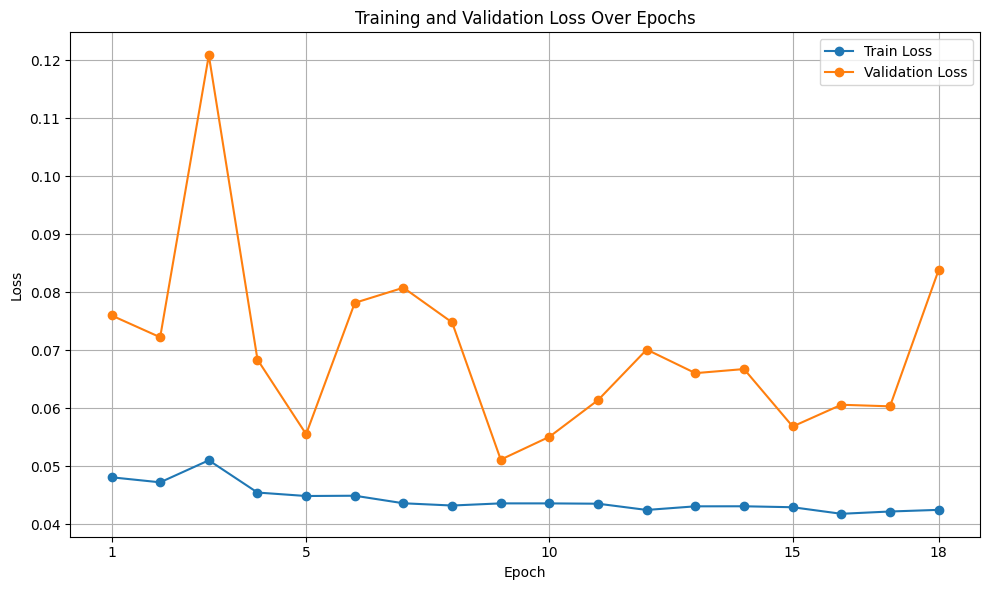

In [65]:
# Plot the training and validation loss history
plot_training_history(final_history, x_tick_interval=5)

In [66]:
# Save the device, scaling_params, and test_df_dates
torch.save((device, scaling_params, test_df_dates), 'device_scaling_params_test_df_dates.pth')

# Download the file
files.download('device_scaling_params_test_df_dates.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [67]:
# Get trained model weights
weights = trained_model.state_dict()
final_weights = final_trained_model.state_dict()

# Save the weights to a file
torch.save(weights, 'trained_model_weights.pth')
torch.save(final_weights, 'final_trained_model_weights.pth')

# Download the file
files.download('trained_model_weights.pth')
files.download('final_trained_model_weights.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
# Load the device, scaling_params, and test_df_dates
device, scaling_params, test_df_dates = torch.load('device_scaling_params_test_df_dates.pth')

In [69]:
# Load the saved weights
loaded_weights = torch.load('trained_model_weights.pth')
final_loaded_weights = torch.load('final_trained_model_weights.pth')

# Load the weights into the model
trained_model.load_state_dict(loaded_weights)
final_trained_model.load_state_dict(final_loaded_weights)

<All keys matched successfully>

# Re-Evaluation

In [70]:
# Get predictions
final_test_preds_inv, test_trues_inv = evaluate_test_set(final_trained_model, test_loader, device, scaling_params)

print(f"\nLength of final_test_preds_inv: {len(final_test_preds_inv)}")
print(f"Length of test_trues_inv: {len(test_trues_inv)}")

Using (mean, std) to inverse transform...

Length of final_test_preds_inv: 318
Length of test_trues_inv: 318


In [71]:
# Save the predictions
torch.save((test_preds_inv, final_test_preds_inv, test_trues_inv), 'test_preds_inv_final_test_preds_inv_test_trues_inv.pth')

# Download the file
files.download('test_preds_inv_final_test_preds_inv_test_trues_inv.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [72]:
# Load the predictions
test_preds_inv, final_test_preds_inv, test_trues_inv = torch.load('test_preds_inv_final_test_preds_inv_test_trues_inv.pth')

In [73]:
# Create metrics DataFrame
final_metrics_df = compute_metrics(final_test_preds_inv, test_trues_inv)
print("Metrics on Test Set:")
display(final_metrics_df)

Metrics on Test Set:


,Value
Metric,
MSE,32.249699
RMSE,5.678882
MAE,4.212625
MAPE (%),8.930261
sMAPE (%),8.397662
MASE,6.290534


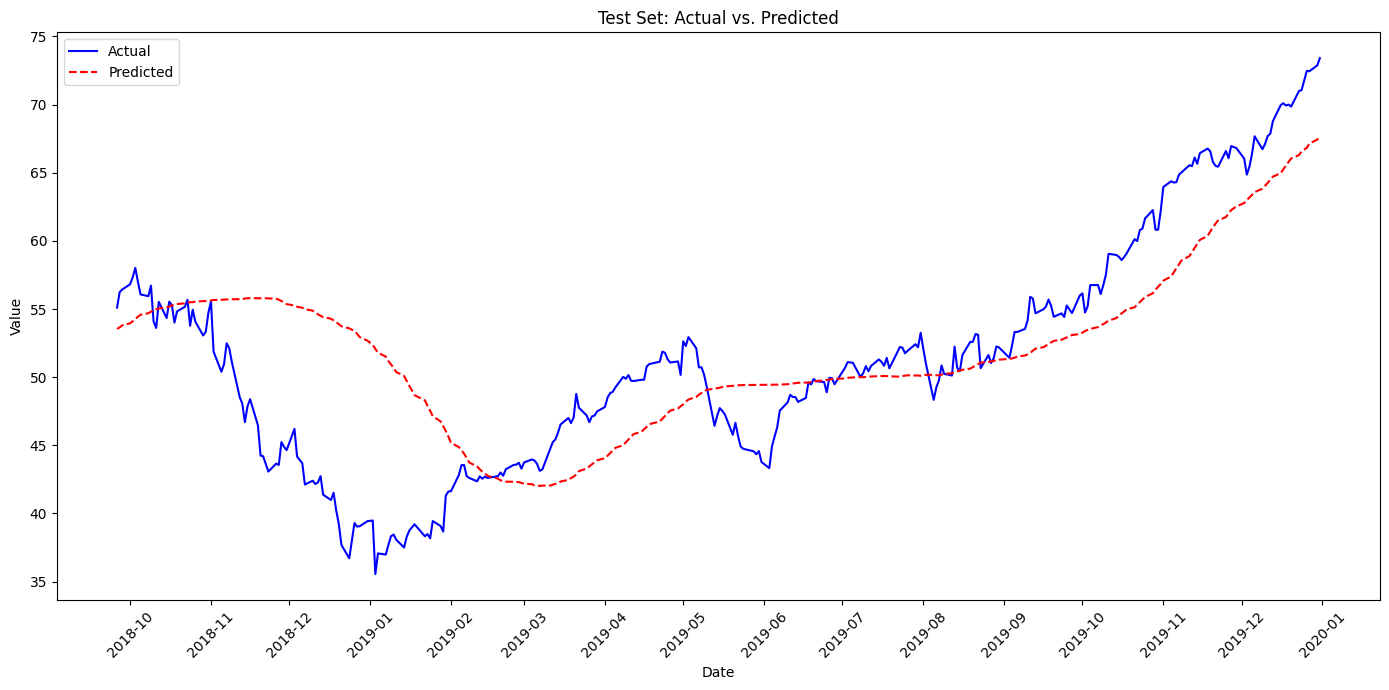

In [74]:
# Plot actual vs. predicted values
plot_test_predictions(
    final_test_preds_inv,
    test_trues_inv,
    test_df_dates,
    tick_interval=tick_interval
)

# Model Comparison

In [75]:
def compare_models_metrics(
    preds1: np.ndarray,
    preds2: np.ndarray,
    actual: np.ndarray,
    model1_name: str,
    model2_name: str,
    desired_order: Optional[List[str]] = None
) -> pd.DataFrame:
    """
    Compare evaluation metrics between two models.

    Computes various metrics (e.g., MSE, RMSE, MAE, MAPE, sMAPE, MASE) for two sets of predictions
    against the actual target values and displays a comparison table.

    Args:
        preds1 (np.ndarray): Predictions from the first model.
        preds2 (np.ndarray): Predictions from the second model.
        actual (np.ndarray): Actual target values.
        model1_name (str): Name of the first model (gets priority in column order).
        model2_name (str): Name of the second model.
        desired_order (Optional[List[str]], optional): Desired order of metrics.
            If None, defaults to ['MSE', 'RMSE', 'MAE', 'MAPE (%)', 'sMAPE (%)', 'MASE'].

    Returns:
        pd.DataFrame: A pivoted DataFrame comparing the two models' metrics.

    Raises:
        ValueError: If the lengths of preds1, preds2, and actual do not match.
    """
    if desired_order is None:
        desired_order = ['MSE', 'RMSE', 'MAE', 'MAPE (%)', 'sMAPE (%)', 'MASE']

    # Validate input lengths
    if not (len(preds1) == len(preds2) == len(actual)):
        raise ValueError("Lengths of preds1, preds2, and actual must be equal.")

    # Compute metrics for both models
    metrics_df1 = compute_metrics(preds1, actual).reset_index()
    metrics_df2 = compute_metrics(preds2, actual).reset_index()

    # Add Model column
    metrics_df1['Model'] = model1_name
    metrics_df2['Model'] = model2_name

    # Combine the DataFrames
    metrics_combined = pd.concat([metrics_df1, metrics_df2], axis=0).reset_index(drop=True)

    # Pivot the combined DataFrame
    metrics_pivot = metrics_combined.pivot(index='Metric', columns='Model', values='Value')

    # Re-order the columns based on model priority (model1 first)
    metrics_pivot = metrics_pivot[[model1_name, model2_name]]

    # Round the values for better readability
    metrics_pivot = metrics_pivot.round(3)

    # Rename the index and columns for clarity
    metrics_pivot.index.name = 'Metric'
    metrics_pivot.columns.name = 'Model'

    # Re-order the rows based on the desired order
    try:
        metrics_pivot = metrics_pivot.loc[desired_order]
    except KeyError as e:
        missing = list(set(desired_order) - set(metrics_pivot.index))
        print(f"Warning: The following metrics are missing and will be skipped: {missing}")
        metrics_pivot = metrics_pivot.loc[metrics_pivot.index.intersection(desired_order)]

    # Display the combined DataFrame
    print("Combined DataFrame:")
    display(metrics_combined)

    # Display the formatted comparison with styling
    print("\nMetrics Comparison:")
    styled_pivot = (
        metrics_pivot.style
        .set_properties(**{'text-align': 'center'})
        .background_gradient(cmap='Blues', axis=None)
        .format("{:.3f}")
    )
    display(styled_pivot)

    return metrics_pivot, styled_pivot

In [76]:
# Compare the tuned model metrics
metrics_pivot, styled_pivot = compare_models_metrics(
    preds1=test_preds_inv,
    preds2=final_test_preds_inv,
    actual=test_trues_inv,
    model1_name='Untuned Model',
    model2_name='Tuned Model',
    desired_order=['MSE', 'RMSE', 'MAE', 'MAPE (%)', 'sMAPE (%)', 'MASE']
)

Combined DataFrame:


,Metric,Value,Model
0,MSE,22.651850,Untuned Model
1,RMSE,4.759396,Untuned Model
2,MAE,3.666930,Untuned Model
3,MAPE (%),7.540182,Untuned Model
4,sMAPE (%),7.252858,Untuned Model
5,MASE,5.475672,Untuned Model
6,MSE,32.249699,Tuned Model
7,RMSE,5.678882,Tuned Model
8,MAE,4.212625,Tuned Model
9,MAPE (%),8.930261,Tuned Model



Metrics Comparison:


Model,Untuned Model,Tuned Model
Metric,,
MSE,22.652,32.250
RMSE,4.759,5.679
MAE,3.667,4.213
MAPE (%),7.540,8.930
sMAPE (%),7.253,8.398
MASE,5.476,6.291


In [77]:
def export_styled_dataframe(
    styled_df: pd.io.formats.style.Styler,
    filename: str = 'styled_dataframe.png',
    show_image: bool = True,
    table_conversion: str = 'selenium'
) -> Optional[bytes]:
    """
    Export a styled pandas DataFrame to an image file and optionally display it within the notebook.

    Converts a styled pandas DataFrame into an image using the specified conversion method,
    saves the image to the designated filename, and displays the image if requested.

    Args:
        styled_df (pd.io.formats.style.Styler): The styled pandas DataFrame to export as an image.
        filename (str, optional): The name of the output image file. Defaults to 'styled_dataframe.png'.
        show_image (bool, optional):
            Flag to determine whether to display the exported image in the notebook.
            If set to `True`, the image will be displayed after export. Defaults to `True`.
        table_conversion (str, optional):
            The method used to convert the DataFrame to an image. Defaults to 'selenium'.

    Returns:
        Optional[bytes]:
            The binary image data of the exported DataFrame if the export is successful.
            Returns `None` if an error occurs during the export process.

    Raises:
        Exception:
            For any other exceptions that occur during the export process.
    """
    try:
        # Create a BytesIO object to hold the image data
        bio = BytesIO()

        # Export the styled DataFrame as an image using the specified conversion method
        dfi.export(
            styled_df,
            bio,
            table_conversion=table_conversion
        )

        # Read the image data from BytesIO
        image_data = bio.getvalue()

        # Save the image data to a file
        with open(filename, 'wb') as f:
            f.write(image_data)

        print(f"Styled DataFrame exported as {filename}\n")

        # Display the image from the saved file if requested
        if show_image:
            display(Image(filename))

        return image_data

    except Exception as e:
        print(f"An error occurred while exporting the DataFrame: {e}")
        return None

Styled DataFrame exported as styled_pivot_table.png



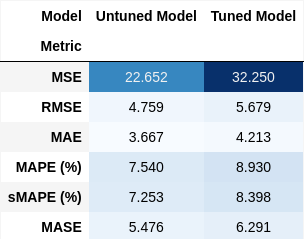

In [78]:
# Exporting and displaying the styled DataFrame
image_data = export_styled_dataframe(
    styled_df=styled_pivot,
    filename='styled_pivot_table.png',
    show_image=True,
    table_conversion='selenium'
)

In [79]:
def plot_side_by_side(
    actual: np.ndarray,
    preds_model1: np.ndarray,
    preds_model2: np.ndarray,
    test_dates: pd.DatetimeIndex,
    model1_name: str = 'Model 1',
    model2_name: str = 'Model 2',
    title1: Optional[str] = None,
    title2: Optional[str] = None,
    tick_interval: str = 'M',
    locator_interval: Optional[int] = None
) -> None:
    """
    Plot actual vs. predicted values for two models side by side with date-based x-axis.

    Creates a figure with two subplots: one for each model's predictions compared to actual values.

    Args:
        actual (np.ndarray): True values of the test set.
        preds_model1 (np.ndarray): Predictions from the first model.
        preds_model2 (np.ndarray): Predictions from the second model.
        test_dates (pd.DatetimeIndex): Dates corresponding to the test set values.
        model1_name (str, optional): Name of the first model. Defaults to 'Model 1'.
        model2_name (str, optional): Name of the second model. Defaults to 'Model 2'.
        title1 (Optional[str], optional): Title for the first subplot.
            If None, defaults to 'Actual vs. {model1_name} Prediction Values'.
        title2 (Optional[str], optional): Title for the second subplot.
            If None, defaults to 'Actual vs. {model2_name} Prediction Values'.
        tick_interval (str, optional): Interval for x-ticks. Options include:
            'D' - Daily
            'W' - Weekly
            'M' - Monthly
            'Q' - Quarterly
            'Y' - Yearly
            Defaults to 'M' for monthly.
        locator_interval (Optional[int], optional): Interval for mdates locator.
            If not provided, defaults based on `tick_interval`. Defaults to None.

    Raises:
        ValueError: If `tick_interval` is not one of the supported options.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

    # Set default locator_interval based on tick_interval if not provided
    if locator_interval is None:
        if tick_interval == 'D':
            locator_interval = 15    # Every 15 days
        elif tick_interval == 'W':
            locator_interval = 2     # Every 2 weeks
        elif tick_interval == 'M':
            locator_interval = 1     # Every month
        elif tick_interval == 'Q':
            locator_interval = 3     # Every quarter
        elif tick_interval == 'Y':
            locator_interval = 1     # Every year
        else:
            raise ValueError(f"Unsupported tick_interval '{tick_interval}'. Choose from 'D', 'W', 'M', 'Q', 'Y'.")

    # Define a helper function to set locators and formatters
    def set_date_locator(ax: plt.Axes, tick_interval: str, locator_interval: int) -> None:
        if tick_interval == 'D':
            locator = mdates.DayLocator(interval=locator_interval)
            formatter = mdates.DateFormatter('%Y-%m-%d')
        elif tick_interval == 'W':
            locator = mdates.WeekdayLocator(interval=locator_interval)
            formatter = mdates.DateFormatter('%Y-%m-%d')
        elif tick_interval == 'M':
            locator = mdates.MonthLocator(interval=locator_interval)
            formatter = mdates.DateFormatter('%Y-%m')
        elif tick_interval == 'Q':
            locator = mdates.MonthLocator(interval=locator_interval)
            formatter = QuarterFormatter()
        elif tick_interval == 'Y':
            locator = mdates.YearLocator(interval=locator_interval)
            formatter = mdates.DateFormatter('%Y')
        else:
            locator = mdates.AutoDateLocator()
            formatter = mdates.DateFormatter('%Y-%m-%d')

        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.tick_params(axis='x', rotation=45)

    # Subplot for the first model
    ax1 = axes[0]
    ax1.plot(test_dates, actual, label='Actual', color='blue')
    ax1.plot(test_dates, preds_model1, label=f'{model1_name} Predictions', color='red', linestyle='--')
    ax1.set_title(title1 if title1 else f'Actual vs. {model1_name} Prediction Values')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Value')
    set_date_locator(ax1, tick_interval, locator_interval)
    ax1.legend()

    # Subplot for the second model
    ax2 = axes[1]
    ax2.plot(test_dates, actual, label='Actual', color='blue')
    ax2.plot(test_dates, preds_model2, label=f'{model2_name} Predictions', color='#E65100', linestyle='--')
    ax2.set_title(title2 if title2 else f'Actual vs. {model2_name} Prediction Values')
    ax2.set_xlabel('Date')
    set_date_locator(ax2, tick_interval, locator_interval)
    ax2.legend()

    plt.tight_layout()
    plt.show()

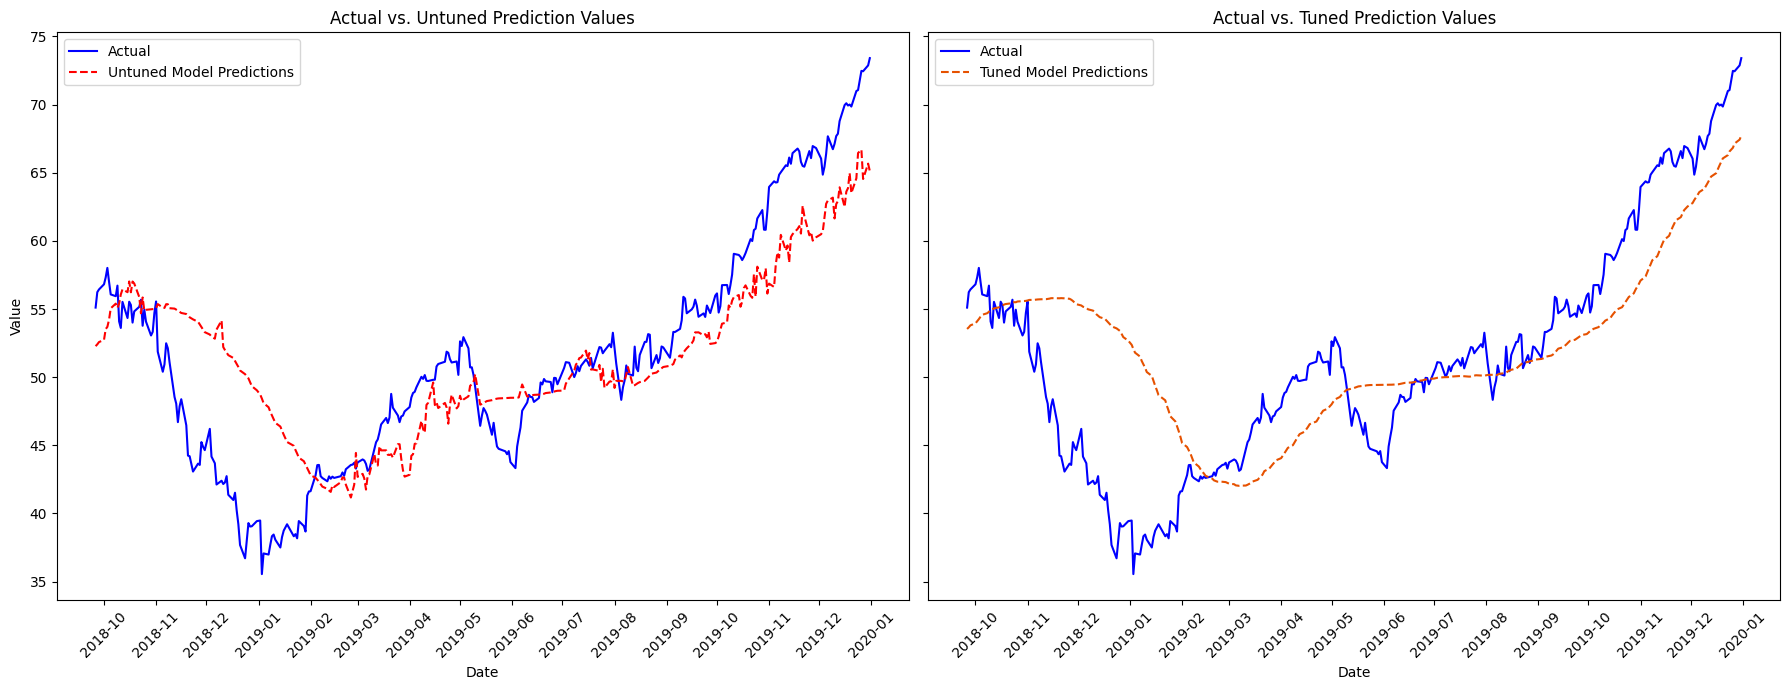

In [80]:
# Plot comparison of actual vs. predicted values
plot_side_by_side(
    actual=test_trues_inv,
    preds_model1=test_preds_inv,
    preds_model2=final_test_preds_inv,
    test_dates=test_df_dates,
    model1_name='Untuned Model',
    model2_name='Tuned Model',
    title1='Actual vs. Untuned Prediction Values',
    title2='Actual vs. Tuned Prediction Values',
    tick_interval=tick_interval
)